In [ ]:
# 2024/04/09 目的:
# 原本使用 best_model 發現883個大腦體積差異>10%
# 現在使用 best_model_ver01 另一個模型，計算左右腦體積差異(絕對值即可) 繪製圖(每一個大腦會有兩個數值(來自不同模型的結果)
# 輸出一張預期斜率=1的圖(每個節點的X軸是 best_model 切割結果的左右MB體積差異百分比，Y軸是 best_model_ver01 切割結果的左右MB體積差異百分比

DLG_shape:  (111, 1024, 1024)


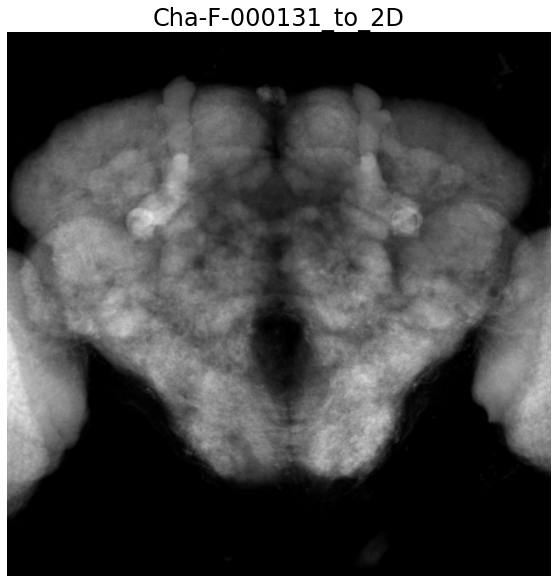

In [4]:
# Step0 讀取883個大腦編號
import numpy as np
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')

# Step0_1 展示測試圖片
# 導入套件
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure

# 記錄開始時間
start_time = time.time()

# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# Step2 讀取檔案名稱列表
brain_files = [s.split('_')[-1] for s in target_files]

# Step3 處理第一個大腦3D影像
brain_file = brain_files[0]  # 選取第一個檔案
DLG = np.load(nii_gz_src + brain_file + '.npy')  # 讀取對應的3D影像
DLG = np.transpose(DLG, (2, 1, 0))
print('DLG_shape: ', DLG.shape)

# 投影成2D圖
projection = np.sum(DLG, axis=0)  # 取加總值
# 顯示2D圖像
plt.figure(figsize=(10, 10))
plt.imshow(projection, cmap='gray')
plt.title(brain_file + '_to_2D', fontsize=24)
plt.axis('off')
plt.show()

# # Step4 將2D圖片輸出至 waiting_for_infer
# projection = projection / np.max(projection) * 255
# im = Image.fromarray(projection.astype('uint8'))  # 要將float32 改成uint8
# im.save('waiting_for_infer/' + brain_file + '.png')


In [7]:
# ==========================設定所有會儲存使用的路徑==========================
# 設定NAS路徑: /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU # 這個通常不會動
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 定義 輸入給yolo的2D圖片資料夾路徑
waiting_for_infer = 'waiting_for_infer_female'

# 定義第一階段輸出資料夾
Step1_output_path = nas_path+'使用者程序_第一階段存檔內容_YOLO提取DLG_客製化數據集'

# 定義第二階段輸出資料夾
Step2_output_path = nas_path+'使用者程序_第二階段存檔內容_完成滑動切割_客製化數據集'

# 定義第三階段輸出資料夾
Step3_output_path = nas_path+'使用者程序_第三階段存檔內容_完成推理_客製化數據集'

# 定義第四階段輸出資料夾
Step4_output_path = nas_path+'使用者程序_第四階段存檔內容_完成還原Z拓展後尺寸_客製化數據集'

# 定義第五階段輸出資料夾
Step5_output_path = nas_path+'使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集'

# 定義 original_info 儲存名稱
original_info_name = 'original_info_客製化數據集'

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
from patchify import patchify, unpatchify
%matplotlib inline
# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

In [8]:
# =========================平行化加速 使用8個cpu運行====只跑一次

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
from patchify import patchify, unpatchify
%matplotlib inline

# 記錄開始時間
start_time = time.time()

# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# =============================測試先只用100個
# 這裡先將全部母果蠅腦全部投影成2D
# brain_files = brain_files[:200]

from concurrent.futures import ThreadPoolExecutor
# 清空並創建 waiting_for_infer 資料夾
if not os.path.exists(waiting_for_infer):
    os.mkdir(waiting_for_infer)
else:
    for file in os.listdir(waiting_for_infer):
        os.remove(waiting_for_infer+'/' + file)
def process_and_save_image(brain_file):
    DLG = np.load(nii_gz_src + brain_file + '.npy')  # 加载3D图像
    DLG = np.transpose(DLG, (2, 1, 0))  # 调整维度顺序
    projection = np.sum(DLG, axis=0)  # 生成2D投影
    projection = projection / np.max(projection) * 255  # 调整亮度
    im = Image.fromarray(projection.astype('uint8'))
    im.save(waiting_for_infer + '/' + brain_file + '.png')

start_time = time.time()

# 使用ThreadPoolExecutor来加速处理
with ThreadPoolExecutor(max_workers=8) as executor:  # 可以根据您的系统调整max_workers的数量
    executor.map(process_and_save_image, brain_files)

end_time = time.time()
print("处理完成，总耗时:", end_time - start_time, "秒")


处理完成，总耗时: 1805.06502699852 秒


In [9]:
# Step4 使用YOLOv7 對 XY view進行預測 seg_target 特徵框========只跑一次
# 輸出的推理結果在: seg_target_small + _inference/detect 資料夾
DLG_src_files = os.listdir(waiting_for_infer)
print('等待推理的圖片數量: ', len(DLG_src_files))

# 清理舊的推理輸出資料夾
# os.system('rm -r ' + seg_target_small + '_inference/user')# 不要刪除之前22835張圖片跟YOLO紀錄

source_path = waiting_for_infer


# 調整信心度閾值和顏色設定
# GT顏色 = #FFC000 在 BGR 表示法中是 (0, 192, 255)
# MB顏色 = #00B0F0 在 BGR 表示法中是 (240, 176, 0)
# AL顏色 = #FF0000 在 BGR 表示法中是 (0, 0, 255)

# 調整信心度閾值並執行 YOLO 推理
# 注意：未來若要偵測其他腦區需要換 weights，並可能需要手動改 al_inference
start_time_YOLO = time.time()  # 記錄開始時間
os.system(f'python detect.py --conf-thres 0.4 --color 240 176 0 '
          f'--weights ./mb_trained/train/exp/weights/best.pt '
          f'--source {source_path} --img-size 640 --save-txt '
          f'--project {seg_target_small}_inference/user > /dev/null 2>&1')
end_time_YOLO = time.time()  # 記錄結束時間
# ==================因為添加  > /dev/null 2>&1 可以讓文字輸出消失==================
# 輸出推理時間
print("YOLO 推理完成，總耗時: {:.2f} 秒".format(end_time_YOLO - start_time_YOLO))

等待推理的圖片數量:  883
YOLO 推理完成，總耗時: 68.30 秒


In [10]:
# 檢查YOLO輸出的圖片和 waiting_for_infer_female 資料夾內的檔案差異
waiting_for_infer_files = os.listdir('waiting_for_infer_female')
after_yolo_file = os.listdir('mb_inference/user/exp4/')

In [ ]:
# =============== 已經完成YOLO偵測目標腦區範圍，可以人工檢查 ===============
# ==============第二步階段: 將目標腦區的範圍進行提取、滑動切割===============

In [11]:
# ========================2024/02/17 批量處理特定範圍 0~4999 or 5000~10000========================
# 重新讀取全部母果蠅的名稱
# brain_files = Brain_18
# brain_files.sort()
# Step5 批量讀取 特別大腦DLG樣本 資料夾內的大腦，並提取範圍內3D影像，再加以拓展進行滑動切割立方體輸出。
import os
import numpy as np
import cv2
start_time_crop_resize = time.time()  # 記錄開始時間

def resize_and_pad(whole_brain, x_start, x_end, y_start, y_end, target_size=168, z_min_size=64, step_of_slide=20):
    """
    对特定区域的大脑进行调整大小和填充
    """
    brain_region = [whole_brain[i, y_start:y_end, x_start:x_end] for i in range(len(whole_brain))]
    brain_region = np.array(brain_region)
    
    # 确定需要缩放还是放大
    if brain_region.shape[1] > target_size:
        resized_brain = np.array([cv2.resize(slice, (target_size, target_size), interpolation=cv2.INTER_AREA) for slice in brain_region])
    else:
        resized_brain = np.array([cv2.resize(slice, (target_size, target_size), interpolation=cv2.INTER_CUBIC) for slice in brain_region])

    # 填充 Z 轴以达到最小尺寸
    num_layers_to_add = 0
    while len(resized_brain) < z_min_size or (len(resized_brain) - z_min_size) % step_of_slide != 0:
        resized_brain = np.append(resized_brain, np.zeros((1, target_size, target_size)), axis=0)
        num_layers_to_add += 1
    print(f'扩展前层数: {brain_region.shape}')
    return resized_brain, num_layers_to_add

def process_brain_region(seg_target, num_of_yolo_box, x1, x2, y1, y2, whole_brain,max_dim=1023):
    """
    处理大脑区域
    """
    original_info = []
    for box_num in range(1, num_of_yolo_box + 1):
        print(f'处理第 {box_num} 个脑区')
        X_start, X_end = x1[box_num - 1], x2[box_num - 1]
        Y_start, Y_end = y1[box_num - 1], y2[box_num - 1]
        X_length, Y_length = X_end - X_start, Y_end - Y_start

#         # 按需要扩展区域
#         if X_length > Y_length:
#             Y_start -= (X_length - Y_length) // 2
#             Y_end += (X_length - Y_length) - (X_length - Y_length) // 2
#         elif Y_length > X_length:
#             X_start -= (Y_length - X_length) // 2
#             X_end += (Y_length - X_length) - (Y_length - X_length) // 2

        # 按需要扩展区域 ===============================這裡確保 X_start 和 Y_start 不小於 0 &  X_end 和 Y_end 不超過最大維度（在這個例子中是 1023）
        if X_length > Y_length:
            Y_start = max(Y_start - (X_length - Y_length) // 2, 0)
            Y_end = min(Y_end + (X_length - Y_length) - (X_length - Y_length) // 2, max_dim)
        elif Y_length > X_length:
            X_start = max(X_start - (Y_length - X_length) // 2, 0)
            X_end = min(X_end + (Y_length - X_length) - (Y_length - X_length) // 2, max_dim)
        # 调整大小和填充
        resized_brain, num_layers_added = resize_and_pad(whole_brain, X_start, X_end, Y_start, Y_end)
        print(f'额外添加层数: {num_layers_added}')
#         print(f'扩展前层数: {len(resized_brain) - num_layers_added}')
        print(f'扩展后层数: {resized_brain.shape}')

        # 计算未来滑动切割生成的 cubes 数量
        future_cubes = ((resized_brain.shape[0] - 64) / Step_of_slide + 1) * ((resized_brain.shape[1] - Size_of_cube) / Step_of_slide + 1) ** 2
        original_info.append([f'{target_name}_No_{box_num}_DLG', X_start, X_end, Y_start, Y_end, len(resized_brain) - num_layers_added, int(future_cubes)])

        # 保存处理后的大脑区域
        np.save(f'{Step1_output_path}/{target_name}_No_{box_num}_DLG', resized_brain)

    return original_info

# 主程序
original_info = []
Step_of_slide, Size_of_cube = 20, 128
# 清空並創建 使用者程序_第一階段存檔內容_YOLO提取DLG 資料夾
if not os.path.exists(Step1_output_path):
    os.mkdir(Step1_output_path)
else:
    for file in os.listdir(Step1_output_path):
        os.remove(Step1_output_path+'/' + file)

for num, target_name in enumerate(brain_files):
    print(num, target_name)
    DLG = np.load(f"/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/{target_name}.npy")
    DLG = np.transpose(DLG, (2, 1, 0))
    print('DLG_shape: ', DLG.shape)
    WholeBrain_DLG_Amira = DLG.copy()

    # 读取 YOLO 检测结果
    txt_path = os.path.join(seg_target_small + '_inference/user/exp4/labels', f'{target_name}.txt')
    try:
        with open(txt_path, 'r') as source_file:
            x1, y1, x2, y2 = [], [], [], []
            for line in source_file:
                class_idx, *bbox = map(float, line.split())
                x_center, y_center, w, h = bbox[0] * DLG.shape[2], bbox[1] * DLG.shape[1], bbox[2] * DLG.shape[2], bbox[3] * DLG.shape[1]
                x1.append(round(x_center - w / 2))
                y1.append(round(y_center - h / 2))
                x2.append(round(x_center + w / 2))
                y2.append(round(y_center + h / 2))

            # 处理每个检测到的大脑区域
            if len(x1) > 0:
                # 2024/03/05 新增判斷式: 因為DLG會有可能出現 1024x1700 or 1700x1024的特殊尺寸
                # 所以要選擇大的邊作為 max_dim
                if DLG.shape[1]>=DLG.shape[2]:
                    
                    original_info += process_brain_region(seg_target, len(x1), x1, x2, y1, y2, WholeBrain_DLG_Amira,max_dim=DLG.shape[1]-1)
                    print('此大腦有',len(x1),'個腦區')
                else:
                    original_info += process_brain_region(seg_target, len(x1), x1, x2, y1, y2, WholeBrain_DLG_Amira,max_dim=DLG.shape[2]-1)
                    print('此大腦有',len(x1),'個腦區')
            else:
                print(f'此大脑没有 {seg_target} 脑区')
    except FileNotFoundError:
        print(f'没有找到 {txt_path}')
end_time_crop_resize = time.time()  # 記錄結束時間
# 儲存 original_info
np.save(original_info_name,original_info)
# 輸出推理時間
print("批量提取腦區3D區域完成，總耗時: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))

0 Cha-F-000131
DLG_shape:  (111, 1024, 1024)
处理第 1 个脑区
扩展前层数: (111, 356, 356)
额外添加层数: 13
扩展后层数: (124, 168, 168)
处理第 2 个脑区
扩展前层数: (111, 344, 344)
额外添加层数: 13
扩展后层数: (124, 168, 168)
此大腦有 2 個腦區
1 5-HT1B-F-400003
DLG_shape:  (113, 1024, 1024)
处理第 1 个脑区
扩展前层数: (113, 302, 302)
额外添加层数: 11
扩展后层数: (124, 168, 168)
处理第 2 个脑区
扩展前层数: (113, 308, 308)
额外添加层数: 11
扩展后层数: (124, 168, 168)
此大腦有 2 個腦區
2 Cha-F-100017
DLG_shape:  (115, 1024, 1024)
处理第 1 个脑区
扩展前层数: (115, 314, 314)
额外添加层数: 9
扩展后层数: (124, 168, 168)
处理第 2 个脑区
扩展前层数: (115, 321, 321)
额外添加层数: 9
扩展后层数: (124, 168, 168)
此大腦有 2 個腦區
3 5-HT1B-F-400004
DLG_shape:  (113, 1024, 1024)
处理第 1 个脑区
扩展前层数: (113, 302, 302)
额外添加层数: 11
扩展后层数: (124, 168, 168)
处理第 2 个脑区
扩展前层数: (113, 308, 308)
额外添加层数: 11
扩展后层数: (124, 168, 168)
此大腦有 2 個腦區
4 Cha-F-000018
DLG_shape:  (125, 1024, 1024)
处理第 1 个脑区
扩展前层数: (125, 349, 349)
额外添加层数: 19
扩展后层数: (144, 168, 168)
处理第 2 个脑区
扩展前层数: (125, 343, 343)
额外添加层数: 19
扩展后层数: (144, 168, 168)
此大腦有 2 個腦區
5 Cha-F-100046
DLG_shape:  (108, 1024, 1024)
处

In [12]:
crop_3D_area_time = end_time_crop_resize - start_time_crop_resize


In [ ]:
# =============== 已經完成YOLO提取3D DLG影像 ===============
# ==============第三步階段: 將提取後的3D DLG進行滑動cubes切割，並輸出===============

In [13]:
#Step6 讀取 使用者程序_第一階段存檔內容_YOLO提取DLG 資料夾內DLG，並進行滑動切割輸出cubes，作為3D UNet輸入
# 讀取 使用者程序_第一階段存檔內容_YOLO提取DLG  資料夾內的DLG檔案
DLG_src_files = os.listdir(Step1_output_path)
DLG_src_files = [i for i in DLG_src_files if '_DLG.npy' in i]
print('大腦數量: ',len(DLG_src_files)/2)
# 將列表從新排列
DLG_src_files.sort()

大腦數量:  883.0


In [ ]:
# Step7 批次讀取單個npy檔案
import numpy as np
import gc
from patchify import patchify

# !rm -r 使用者程序_第二階段存檔內容_完成滑動切割
# !mkdir 使用者程序_第二階段存檔內容_完成滑動切割

# 清空並創建 使用者程序_第二階段存檔內容_完成滑動切割 資料夾
if not os.path.exists(Step2_output_path):
    os.mkdir(Step2_output_path)
else:
    for file in os.listdir(Step2_output_path):
        os.remove(Step2_output_path+'/' + file)
        
        
def normalize_image(img, lower_bound=0, upper_bound=255):
    """ 将图像标准化到指定的亮度范围内 """
    if np.min(img) < lower_bound or np.max(img) > upper_bound:
        img = img - np.min(img)
        img = img / np.max(img) * upper_bound
    return img

def process_and_patch(npy_file, size_of_cube, step_of_slide):
    """ 对单个 NPY 文件进行处理和滑动切割 """
    npy_file = normalize_image(npy_file)
    npy_file_patches = patchify(npy_file, (64, size_of_cube, size_of_cube), step=step_of_slide)
    return np.reshape(npy_file_patches, (-1, npy_file_patches.shape[3], npy_file_patches.shape[4], npy_file_patches.shape[5]))
# 主程序
Size_of_cube = 128  # 长宽尺寸
Step_of_slide = 20  # 滑动步数
DLG_src_files = os.listdir(Step1_output_path)
DLG_src_files.sort()

output_dir = Step2_output_path
os.makedirs(output_dir, exist_ok=True)

start_time_crop_resize = time.time()

for i, file_name in enumerate(DLG_src_files):
    npy_file = np.load(f'{Step1_output_path}/{file_name}')
    print(file_name)
    input_npy_file_patches = process_and_patch(npy_file, Size_of_cube, Step_of_slide)
    # 为每个文件保存独立的切片
    np.save(f'{output_dir}/{file_name}', input_npy_file_patches)
    print(input_npy_file_patches.shape)
    del input_npy_file_patches
    gc.collect()

end_time_crop_resize = time.time()

# 輸出推理时间
print("批量滑动切割 cubes 完成，总耗时: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))
# # 主程序
# Size_of_cube = 128  # 长宽尺寸
# Step_of_slide = 20  # 滑动步数
# DLG_src_files = os.listdir('使用者程序_第一階段存檔內容_YOLO提取DLG')
# # 將列表從新排列
# DLG_src_files.sort()

# test_img = None
# for i, file_name in enumerate(DLG_src_files[:3]):
#     npy_file = np.load(f'使用者程序_第一階段存檔內容_YOLO提取DLG/{file_name}')
#     print(file_name)
#     input_npy_file_patches = process_and_patch(npy_file, Size_of_cube, Step_of_slide)
#     test_img = input_npy_file_patches if i == 0 else np.append(test_img, input_npy_file_patches, axis=0)
#     del input_npy_file_patches
#     gc.collect()
# end_time_crop_resize = time.time()  # 記錄結束時間

# # 輸出推理時間
# print("批量滑動切割cubes完成，總耗時: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))
# test_img.shape

# # 创建输出目录并保存 test_img
# output_dir = '使用者程序_第二階段存檔內容_完成滑動切割'
# os.makedirs(output_dir, exist_ok=True)
# np.save(f'{output_dir}/DLG_INPUT', test_img)

5-HT1B-F-400003_No_1_DLG.npy
(36, 64, 128, 128)
5-HT1B-F-400003_No_2_DLG.npy
(36, 64, 128, 128)
5-HT1B-F-400004_No_1_DLG.npy
(36, 64, 128, 128)
5-HT1B-F-400004_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-000002_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-000002_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-100033_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-100033_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-300033_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-300033_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-300034_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-300034_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-400029_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-400029_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-500000_No_1_DLG.npy
(36, 64, 128, 128)
5HT1A-F-500000_No_2_DLG.npy
(36, 64, 128, 128)
5HT1A-F-500009_No_1_DLG.npy
(27, 64, 128, 128)
5HT1A-F-500009_No_2_DLG.npy
(27, 64, 128, 128)
5HT1A-F-600005_No_1_DLG.npy
(63, 64, 128, 128)
5HT1A-F-600005_No_2_DLG.npy
(63, 64, 128, 128)
5HT1A-F-700018_No_1_DLG.npy
(45, 64, 128, 128)
5HT1A-F-7

In [ ]:
slide_crop_cubes_time = end_time_crop_resize - start_time_crop_resize

In [ ]:
# =============== 已經完成滑動切割，提供給3D UNet模型推理 ===============
# ==============第四步階段: 使用3D UNet模型推理===============

In [ ]:
# 先導入之前儲存的 original_info
original_info = np.load(original_info_name+'.npy')
# 轉換函數
def convert_array_elements(arr):
    # 將第一個元素保留為字符串，其餘轉換為整數
    return (arr[0],) + tuple(int(x) for x in arr[1:])

# 應用轉換
converted_info = [convert_array_elements(row) for row in original_info]
original_info = converted_info
# 檢查轉換後的結果和類型
type(original_info[0][1])

In [ ]:
# Step8 導入套件和模型


import tensorflow as tf
from tensorflow import keras
from segmentation_models_3D import get_preprocessing
from patchify import unpatchify
import numpy as np
import os
import time

# 设置 GPU 和模型
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)
# 可以更換模型 best_model_ver01.h5 or best_model
my_model = keras.models.load_model(seg_target+'最佳模型/best_model_ver01.h5', compile=False)

# Step9 載入滑動切割後的檔案
# 批量处理 npy 文件
input_dir = Step2_output_path
# 清空並創建 使用者程序_第三階段存檔內容_完成推理 資料夾
if not os.path.exists(Step3_output_path):
    os.mkdir(Step3_output_path)
else:
    for file in os.listdir(Step3_output_path):
        os.remove(Step3_output_path+'/' + file)    
output_dir = Step3_output_path

start_time_seg = time.time()

for file_info in original_info:
    file_name = file_info[0] + '.npy'
    test_img = np.load(os.path.join(input_dir, file_name))
    test_img = np.stack((test_img,) * 1, axis=-1)
    test_img_input = preprocess_input(test_img)

    test_pred = my_model.predict(test_img_input, batch_size=1)
    test_pred = np.argmax(test_pred, axis=4)

    predicted_reshaped = np.reshape(test_pred, (int(int(file_info[-1]) / 9), 3, 3, 64, 128, 128))
    print(predicted_reshaped.shape)
    np.save(os.path.join(output_dir, file_name.replace('.npy', '_predicted')), predicted_reshaped)

    del test_img, test_img_input, test_pred, predicted_reshaped
    gc.collect()

end_time_seg = time.time()
print("批量推理完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))


In [ ]:
UNet_time = end_time_seg - start_time_seg

In [ ]:
# Step9 定義 _unpatchify3d 函數
from typing import Tuple, Union, cast
Imsize = Union[Tuple[int, int], Tuple[int, int, int]]
def _unpatchify3d(  # pylint: disable=too-many-locals
    patches: np.ndarray, imsize: Tuple[int, int, int]
) -> np.ndarray:
    assert len(patches.shape) == 6
    i_h, i_w, i_c = imsize
    image = np.zeros(imsize, dtype=patches.dtype)
    n_h, n_w, n_c, p_h, p_w, p_c = patches.shape
    s_w = 0 if n_w <= 1 else (i_w - p_w) / (n_w - 1)
    s_h = 0 if n_h <= 1 else (i_h - p_h) / (n_h - 1)
    s_c = 0 if n_c <= 1 else (i_c - p_c) / (n_c - 1)
    # The step size should be same for all patches, otherwise the patches are unable
    # to reconstruct into a image
    if int(s_w) != s_w:
        raise NonUniformStepSizeError(i_w, n_w, p_w, s_w)
    if int(s_h) != s_h:
        raise NonUniformStepSizeError(i_h, n_h, p_h, s_h)
    if int(s_c) != s_c:
        raise NonUniformStepSizeError(i_c, n_c, p_c, s_c)
    s_w = int(s_w)
    s_h = int(s_h)
    s_c = int(s_c)

    i, j, k = 0, 0, 0
    while True:
        i_o, j_o, k_o = i * s_h, j * s_w, k * s_c
        # 原本合併(直接賦予數值)
        #image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = patches[i, j, k]
        # 修改成累加(投票)
        image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] + patches[i, j, k]

        if k < n_c - 1:
            k = min((k_o + p_c) // s_c, n_c - 1)
        elif j < n_w - 1 and k >= n_c - 1:
            j = min((j_o + p_w) // s_w, n_w - 1)
            k = 0
        elif i < n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            i = min((i_o + p_h) // s_h, n_h - 1)
            j = 0
            k = 0
        elif i >= n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            # Finished
            break
        else:
            raise RuntimeError("Unreachable")
    return image

In [20]:
# Step10 使用unpatchify對預測結果還原成Z軸拓展後的 尺寸(124,168,168) or (144,168,168)
import numpy as np
import os
from skimage import measure
start_time_seg = time.time()
# 清空並創建 使用者程序_第四階段存檔內容_完成還原Z拓展後尺寸_母果蠅 資料夾
if not os.path.exists(Step4_output_path):
    os.mkdir(Step4_output_path)
else:
    for file in os.listdir(Step4_output_path):
        os.remove(Step4_output_path+'/' + file)  
        
def get_reconstructed_size(original_z, target_size=168, step_of_slide=20, z_min_size=64):
    """ 计算还原后的尺寸 """
    num_layers_to_add = 0
    while original_z + num_layers_to_add < z_min_size or (original_z + num_layers_to_add - z_min_size) % step_of_slide != 0:
        num_layers_to_add += 1
    return original_z + num_layers_to_add
def save_reconstructed_images(original_info, output_dir, prefix=Step3_output_path+'/'):
    """ 批量保存重建的影像 """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, info in enumerate(original_info):
        file_name = info[0] + '_predicted.npy'
        predicted_reshaped = np.load(prefix + file_name)

        reconstructed_size = get_reconstructed_size(info[5])
        reconstructed = _unpatchify3d(predicted_reshaped, (reconstructed_size, 168, 168))
        reconstructed[reconstructed > 0] = 1
        # ==============================2024/02/05 新增去除雜訊==============================
        # from skimage import measure
        # reconstructed
        labels = measure.label(reconstructed, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
        regions = measure.regionprops(labels)
        # 計算封閉區域的數量
        num_regions = len(regions)
        print(info[0])
        # 計算每個區域的像素數量
        for region in regions:
            print("Region area: ", region.area)
        print("Number of closed areas: ", num_regions)
        # 找到最大的Region area
        # =================2024/02/20 ==========新增判斷式(因為YOLO會偵測到3個腦區，3D UNet 推理後會是空矩陣)
        # 跳過 np.max(reconstructed)<1的檔案
        if np.max(reconstructed)<1:
            # 保存重建的影像
            np.save(os.path.join(output_dir, info[0] + '_reconstructed.npy'), reconstructed)
            continue
        else:

            max_area_index = np.argmax([region.area for region in regions])
            # 設置除了最大的Region area之外的所有區域為0
            for i, region in enumerate(regions):
                if i != max_area_index:
                    reconstructed[tuple(region.coords.T)] = 0
            # 將大於0的位置設為1
            reconstructed[reconstructed>0] =1
            # ==========================================================================================
            # 保存重建的影像
            np.save(os.path.join(output_dir, info[0] + '_reconstructed.npy'), reconstructed)
        # =======================================================
# 使用函数保存重建的影像
output_dir = Step4_output_path
save_reconstructed_images(original_info, output_dir)
end_time_seg = time.time()
print("預測結果完成還原Z拓展，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

Cha-F-400065_No_2_DLG
Region area:  199
Region area:  180757
Region area:  1
Region area:  416
Region area:  3335
Region area:  280
Number of closed areas:  6
Cha-F-300412_No_1_DLG
Region area:  199062
Region area:  177
Number of closed areas:  2
Cha-F-300412_No_2_DLG
Region area:  170505
Region area:  1245
Number of closed areas:  2
Cha-F-400066_No_1_DLG
Region area:  148757
Region area:  23
Region area:  2
Region area:  1
Region area:  4
Region area:  509
Region area:  6
Region area:  190
Region area:  5047
Number of closed areas:  9
Cha-F-400066_No_2_DLG
Region area:  199
Region area:  180757
Region area:  1
Region area:  416
Region area:  3335
Region area:  280
Number of closed areas:  6
Cha-F-400208_No_1_DLG
Region area:  168065
Region area:  8
Region area:  25
Region area:  5
Region area:  44
Region area:  4
Region area:  1719
Number of closed areas:  7
Cha-F-400208_No_2_DLG
Region area:  203602
Region area:  14
Region area:  15
Number of closed areas:  3
Cha-F-400099_No_1_DLG
Re

In [21]:
back_to_Z_extanding_time = end_time_seg - start_time_seg

In [22]:
# Step11  將模型切割的腦區縮放回原始解析度
from skimage import measure
import numpy as np
import cv2
import os
start_time_seg = time.time()
def resize_reconstructed(reconstructed, original_X_width, original_Y_width, target_size=168):
    """根据原始宽度调整重建影像的大小"""
    resized = []
    for slice in reconstructed:
        # 如果原始宽度小于目标大小，则使用INTER_AREA进行缩小 (INTER_AREA 效果很好)
        if original_X_width < target_size and original_Y_width < target_size:
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_AREA)
        # 如果原始宽度大于目标大小，则使用INTER_CUBIC进行放大
        elif original_X_width > target_size and original_Y_width > target_size:
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_CUBIC)
        # 如果原始宽度等于目标大小，则不需要调整大小
        else:
            # 如果原始尺寸跟切割完的相比有大有小，優先選擇縮小演算法去還原回 original_X_width
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_AREA)
        resized.append(resized_slice)
    return np.array(resized)


def process_and_save_reconstructed_images(input_dir, original_info):
    """批量处理并保存重建的影像"""
    for info in original_info:
        file_name = info[0] + '_reconstructed.npy'
        reconstructed = np.load(os.path.join(input_dir, file_name))
        #============注意!! 因 DLG[:,info[3]:info[4],info[1]:info[2]] 不一定每一個腦區區域都是正方形
        #============DLG是 Z Y X 順序
        #============所以寬不能統一只用一個數值
        original_X_width = abs(info[1] - info[2])
        original_Y_width = abs(info[3] - info[4])
        print('這個檔案名稱:',file_name)
        print('X寬:',original_X_width)
        print('Y寬:',original_Y_width)
# #         =======================2024/02/20 上一個步驟已經做過一次 measure 排除小雜訊，=======================
#         # 使用 skimage.measure 处理
#         labels = measure.label(reconstructed, connectivity=1)
#         regions = measure.regionprops(labels)
#         max_area_index = np.argmax([region.area for region in regions])

#         for i, region in enumerate(regions):
#             if i != max_area_index:
#                 reconstructed[tuple(region.coords.T)] = 0

#         reconstructed[reconstructed > 0] = 1
# #         =======================2024/02/20 上一個步驟已經做過一次 measure 排除小雜訊，=======================

        # 删除额外添加的 Z 轴层
        need_del_num = abs(info[5] - len(reconstructed))
        if need_del_num != 0:
            reconstructed = np.delete(reconstructed, slice(-need_del_num, None), axis=0)
            
        # 將 reconstructed 轉換數據格式 成 uint8
        reconstructed = reconstructed.astype('uint8')
        # 调整大小
        reconstructed_resized = resize_reconstructed(reconstructed, original_X_width,original_Y_width)
        print('完成還原原始解析度尺寸:',reconstructed_resized.shape)
        # 保存处理后的影像
        np.save(os.path.join(input_dir, file_name), reconstructed_resized)

# 使用函数处理并保存重建的影像
input_dir = Step4_output_path
process_and_save_reconstructed_images(input_dir, original_info)
end_time_seg = time.time()
print("完成還原原始解析度，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

這個檔案名稱: Cha-F-000131_No_1_DLG_reconstructed.npy
X寬: 356
Y寬: 356
完成還原原始解析度尺寸: (111, 356, 356)
這個檔案名稱: Cha-F-000131_No_2_DLG_reconstructed.npy
X寬: 344
Y寬: 344
完成還原原始解析度尺寸: (111, 344, 344)
這個檔案名稱: 5-HT1B-F-400003_No_1_DLG_reconstructed.npy
X寬: 302
Y寬: 302
完成還原原始解析度尺寸: (113, 302, 302)
這個檔案名稱: 5-HT1B-F-400003_No_2_DLG_reconstructed.npy
X寬: 308
Y寬: 308
完成還原原始解析度尺寸: (113, 308, 308)
這個檔案名稱: Cha-F-100017_No_1_DLG_reconstructed.npy
X寬: 314
Y寬: 314
完成還原原始解析度尺寸: (115, 314, 314)
這個檔案名稱: Cha-F-100017_No_2_DLG_reconstructed.npy
X寬: 321
Y寬: 321
完成還原原始解析度尺寸: (115, 321, 321)
這個檔案名稱: 5-HT1B-F-400004_No_1_DLG_reconstructed.npy
X寬: 302
Y寬: 302
完成還原原始解析度尺寸: (113, 302, 302)
這個檔案名稱: 5-HT1B-F-400004_No_2_DLG_reconstructed.npy
X寬: 308
Y寬: 308
完成還原原始解析度尺寸: (113, 308, 308)
這個檔案名稱: Cha-F-000018_No_1_DLG_reconstructed.npy
X寬: 349
Y寬: 349
完成還原原始解析度尺寸: (125, 349, 349)
這個檔案名稱: Cha-F-000018_No_2_DLG_reconstructed.npy
X寬: 343
Y寬: 343
完成還原原始解析度尺寸: (125, 343, 343)
這個檔案名稱: Cha-F-100046_No_1_DLG_reconstructed.npy
X寬: 360
Y寬

In [23]:
finish_original_time = end_time_seg - start_time_seg

In [24]:
# Step12 將原始解析度的腦區結果放回原始畫布
start_time_seg = time.time()
# 清空並創建 使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅 資料夾
if not os.path.exists(Step5_output_path):
    os.mkdir(Step5_output_path)
else:
    for file in os.listdir(Step5_output_path):
        os.remove(Step5_output_path+'/' + file)  
        
        
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

input_dir = Step4_output_path

# 讀取資料夾"nii_gz_src"內原始大腦npy檔案，獲取空白畫布，並將腦區切割結果放入
# 最終目的: 將合併結果和原始DLG都分別輸出至 "使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅"
# 讀取檔案名稱列表
# brain_files = np.load("2024_100個篩選同方向的_female_brain_files.npy")# ===========先處理母果蠅
# brain_files.sort()
# =============2024/02/17 因為最前方有規定批次處理的範圍0~4999 or 5000~10000 所以這邊就不重新讀取檔案名稱=============


# 用雙層迴圈處理: 外層是資料夾內原始大腦數量，內層是已經完成切割的腦區數量
for ii in brain_files:
    # ii == 本次處理的大腦名稱
    DLG = np.load(nii_gz_src + ii + '.npy')  # 讀取對應的3D影像
    DLG = np.transpose(DLG, (2, 1, 0))  # 調整維度順序
    
    # 也同時輸出原始DLG的tif檔案(這樣在Avizo視覺化才會匹配位置)
    #tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/原始大腦尺寸_原始DLG_'+DLG_files[ii].split(".")[0]+'.tif',DLG.astype('uint16'))
    tif.imsave(Step5_output_path+'/DLG_'+ii+'.tif',DLG.astype('uint16'))

    # 清空DLG，只保留尺寸
    DLG = DLG*0
    
    # 這個迴圈是要先檢查目前處理的大腦名稱 ii 對應的切割結果
    
    
    for info in original_info:
        file_name = info[0] + '_reconstructed.npy'
        # 檢查腦區變數名稱和原始大腦名稱是否匹配，若匹配則將腦區加入此大腦畫布
        if ii in file_name:
            reconstructed = np.load(os.path.join(input_dir, file_name))
            print('目前處理: ',file_name)
            print('腦區放回前最大值: ',np.max(DLG))
            # 開始將腦區結果放回 !! 注意: DLG是 Z Y X 順序 修改成空白DLG和腦區結果相加
            # 因為如果直接賦予數值會因為Bounding Box重疊而發生腦區被切掉，用相加在用二值化即可
            DLG[:,info[3]:info[4],info[1]:info[2]] = DLG[:,info[3]:info[4],info[1]:info[2]] + reconstructed
            print('腦區放回後最大值: ',np.max(DLG))
    DLG[DLG>1]=1 # 重疊腦區的位置也改成1
    print('----------------查看--------------')
    tif.imsave(Step5_output_path+'/Seg_'+seg_target+'_'+ii+'.tif',DLG.astype('uint16'))
    # 最後將DLG & Seg 結果都輸出到 特殊果蠅腦_視覺化資料夾，以便後續和其他腦區合併
    
end_time_seg = time.time()
print("完成輸出大腦DLG和Seg結果tif檔案，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
    
    
    

目前處理:  Cha-F-000131_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  Cha-F-000131_No_2_DLG_reconstructed.npy
腦區放回前最大值:  1
腦區放回後最大值:  1
----------------查看--------------
目前處理:  5-HT1B-F-400003_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  5-HT1B-F-400003_No_2_DLG_reconstructed.npy
腦區放回前最大值:  1
腦區放回後最大值:  1
----------------查看--------------
目前處理:  Cha-F-100017_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  Cha-F-100017_No_2_DLG_reconstructed.npy
腦區放回前最大值:  1
腦區放回後最大值:  1
----------------查看--------------
目前處理:  5-HT1B-F-400004_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  5-HT1B-F-400004_No_2_DLG_reconstructed.npy
腦區放回前最大值:  1
腦區放回後最大值:  1
----------------查看--------------
目前處理:  Cha-F-000018_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  Cha-F-000018_No_2_DLG_reconstructed.npy
腦區放回前最大值:  1
腦區放回後最大值:  1
----------------查看--------------
目前處理:  Cha-F-100046_No_1_DLG_reconstructed.npy
腦區放回前最大值:  0
腦區放回後最大值:  1
目前處理:  Cha-F-100046_

In [25]:
finish_dlg_seg_to_sif_time = end_time_seg - start_time_seg

In [26]:
# 將所有時間加總並/1000
all_time = finish_dlg_seg_to_sif_time+crop_3D_area_time+slide_crop_cubes_time+UNet_time+back_to_Z_extanding_time+finish_original_time
print('每個大腦平均切割時間:',all_time/1000,'秒')

每個大腦平均切割時間: 36.753130098581316 秒


In [27]:
# ========================下面要開始統計883個大腦左右腦體積差異百分比(絕對值)
# ===================================平行化測試=================================== 0~883
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# # 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
# stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]
stage_five_folders = ['使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集']
# ============================================使用迴圈處理 stage_five_folders 所有資料夾============================================
for iiii in range(len(stage_five_folders)):

    # =============================先測試0~1000=============================
    folder = stage_five_folders[iiii]
    # 未來希望平行化處理 stage_five_folders 所有的資料夾 stage_five_folders[0..1..2..3.....]
    folder_path = os.path.join(nas_path, folder)
    print('本次處理的資料夾名稱: ',folder_path)
    # 搜尋該資料夾內所有的 Label 檔案
    label_files = glob.glob(os.path.join(folder_path, 'Seg*'))
    label_files.sort()

    # 定义处理单个文件的函数
    def process_file(file_path):
        try:
            label = tif.imread(file_path)
            labels = measure.label(label, connectivity=1)
            regions = measure.regionprops(labels)
            regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)

            if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
                # 返回 None 或其他标志以表示跳过的文件
                return file_path, None, None

            left_brain = np.zeros_like(label)
            right_brain = np.zeros_like(label)

            centroid1 = regions_sorted_by_area[0].centroid
            centroid2 = regions_sorted_by_area[1].centroid
            left_index, right_index = (0, 1) if centroid1[2] < centroid2[2] else (1, 0)

            for coord in regions_sorted_by_area[left_index].coords:
                left_brain[coord[0], coord[1], coord[2]] = 1
            for coord in regions_sorted_by_area[right_index].coords:
                right_brain[coord[0], coord[1], coord[2]] = 1

            return file_path, np.sum(left_brain), np.sum(right_brain)
        except Exception as e:
            return file_path, None, None

    # 使用 ThreadPoolExecutor 来并行处理文件
    with ThreadPoolExecutor(max_workers=8) as executor:
        # 提交所有文件到线程池
        futures = [executor.submit(process_file, file_path) for file_path in label_files]

        # 初始化列表用于存储结果
        used_files = []
        left_volumes = []
        right_volumes = []

        # 等待每个任务完成并处理结果
        for future in as_completed(futures):
            file_path, left_volume, right_volume = future.result()
            if left_volume is not None and right_volume is not None:
                # 根据需要处理有效结果
                used_files.append(file_path.split('/')[-1][:-4])
                left_volumes.append(left_volume)
                right_volumes.append(right_volume)


    # 製作成列表，並計算出 absolute_percentage_differences
    # 转换为浮点型以避免溢出
    left_volumes_float = [float(v) for v in left_volumes]
    right_volumes_float = [float(v) for v in right_volumes]
    # 计算平均体积
    average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

    # 计算体积差异及其百分比
    volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
    percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

    # 取絕對值
    absolute_percentage_differences = [abs(x) for x in percentage_differences]

    # 輸出儲存 used_files & absolute_percentage_differences

    # 从 folder 变量提取范围信息
#     range_info = folder.split('母果蠅_')[-1]   # 例如："0_1000"

    # 文件名前缀
    file_name_prefix = '客製化數據集'  # 例如："0_1000" OR "客製化數據集"

    # 保存 used_files 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的檔案名稱.npy', np.array(used_files))

    # 保存 absolute_percentage_differences 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(absolute_percentage_differences))

    print(f"已保存：\n{file_name_prefix}_有處理的檔案名稱.npy\n{file_name_prefix}_有處理的體積誤差百分比.npy")
    end_time_seg = time.time()
    print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
    print('=====================================================')

本次處理的資料夾名稱:  /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集
已保存：
客製化數據集_有處理的檔案名稱.npy
客製化數據集_有處理的體積誤差百分比.npy
完成，总耗时: 1807.74 秒


In [1]:
# =======================================只須執行下面=======================================

In [ ]:
# # 定义要删除的大脑ID列表
# ids_to_remove = ['Seg_MB_VGlut-F-000542',
#        'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# # # 使用列表推导式从 target_brain_ids 中排除特定的大脑ID
# # filtered_brain = [id for id in target_files if id not in ids_to_remove]
# # 过滤掉特定的大脑ID及其对应的数值
# filtered_brain_ids = []
# filtered_percentages = []

# for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
#     if brain_id not in ids_to_remove:
#         filtered_brain_ids.append(brain_id)
#         filtered_percentages.append(percentage)

# # # 若要使用有刪除特定大腦版本，提取大脑ID
# target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
# target_absolute_percentage_differences = filtered_percentages

Slope: 0.9662792790575043


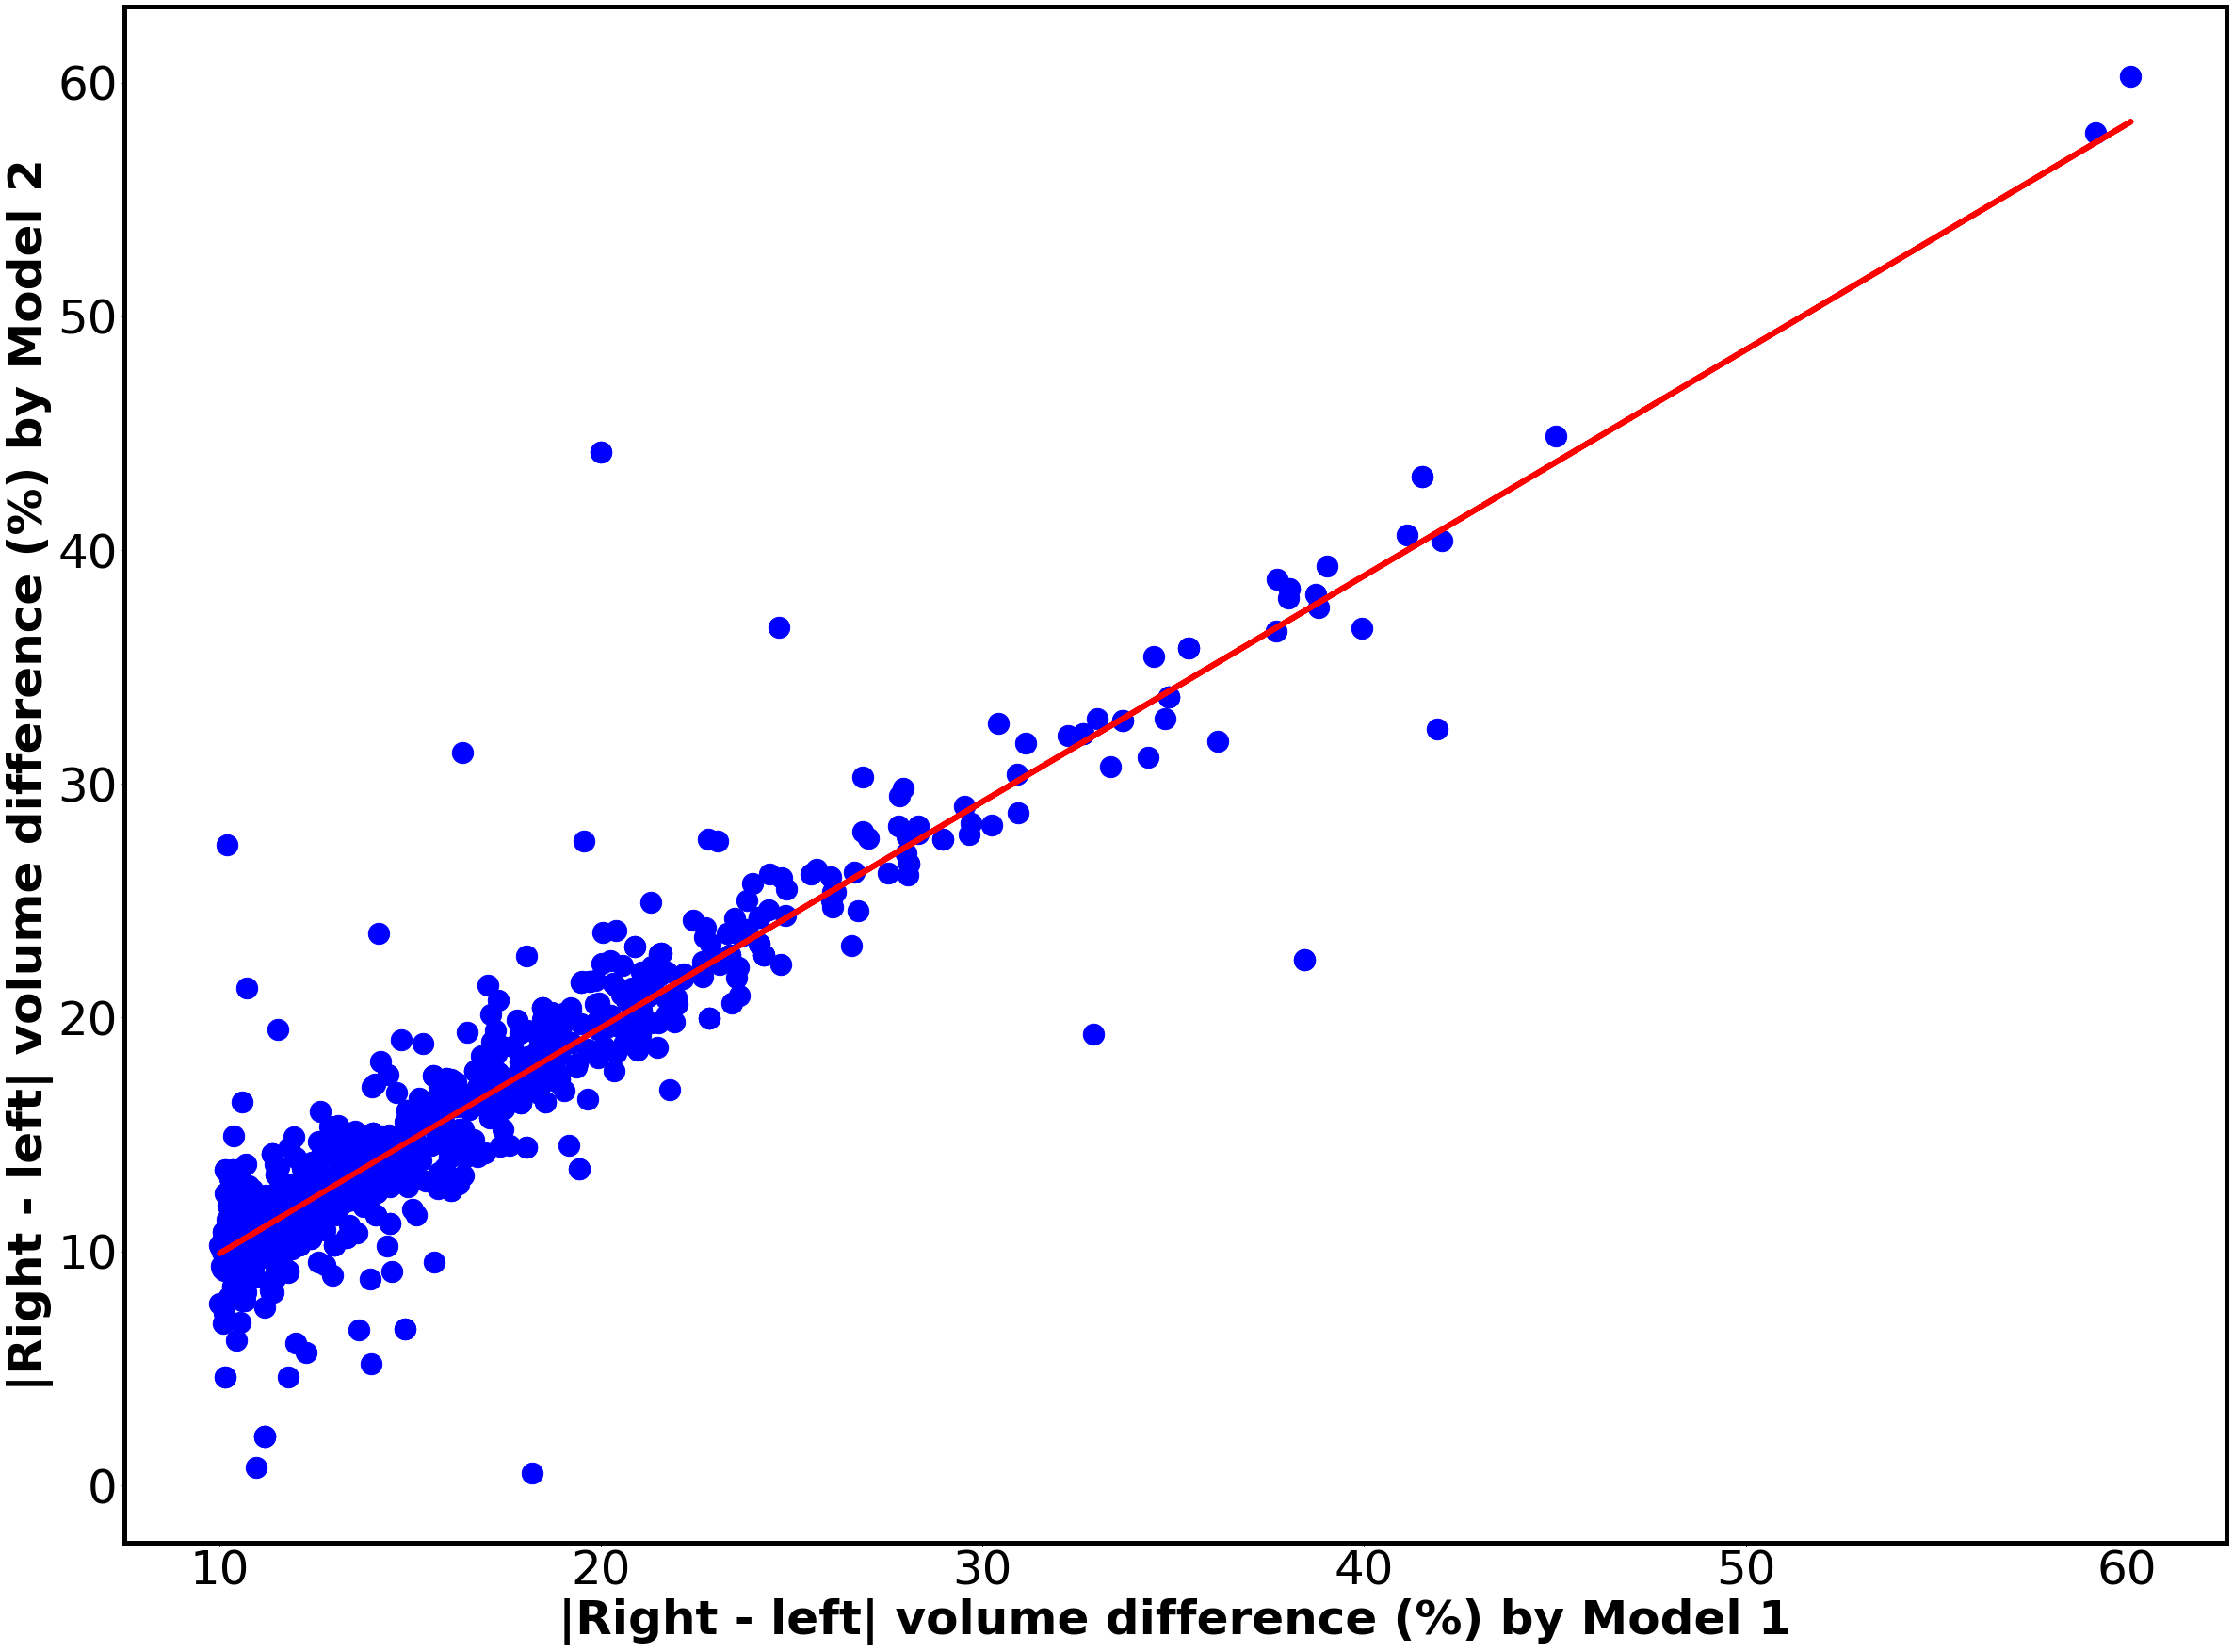

In [1]:
# 讀取已經處理好的檔案名稱和體積差異百分比(2號模型結果)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy')
# 因為一號模型結果有人工驗證所以有區分左右腦，現在統一用絕對值
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 提取大脑ID (原始)
# target_brain_ids = [s.split('_')[-1] for s in target_files]

# 定义要删除的大脑ID列表
ids_to_remove = ['Seg_MB_VGlut-F-000542',
       'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# # 使用列表推导式从 target_brain_ids 中排除特定的大脑ID
# filtered_brain = [id for id in target_files if id not in ids_to_remove]
# 过滤掉特定的大脑ID及其对应的数值
filtered_brain_ids = []
filtered_percentages = []

for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
    if brain_id not in ids_to_remove:
        filtered_brain_ids.append(brain_id)
        filtered_percentages.append(percentage)
# 將刪除後的大腦名稱列表賦予回原本 target_files
target_files = filtered_brain_ids
# # 若要使用有刪除特定大腦版本，提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
target_absolute_percentage_differences = filtered_percentages
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])


x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算斜率和截距
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 打印斜率
print(f'Slope: {slope}')

# 绘制散点图和回归线
plt.figure(figsize=(40, 30))
plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference',s=500)
plt.plot(x_coords, intercept + slope * x_coords, 'r-', label=f'Fit Line (slope = {slope:.2f})', linewidth=6)  # 增加 linewidth 参数
# plt.title('Left-Right MB Neuropil Volume Difference Comparison Across Models',size=40)
plt.xlabel('|Right - left| volume difference (%) by Model 1',size=50, fontweight='bold')
plt.ylabel('|Right - left| volume difference (%) by Model 2',size=50, fontweight='bold')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
# plt.grid(True)
# plt.legend(fontsize=28)
ax = plt.gca()  # 獲取當前的Axes對象ax
for spine in ax.spines.values():
    spine.set_linewidth(5)  # 設定邊框線的寬度
plt.show()

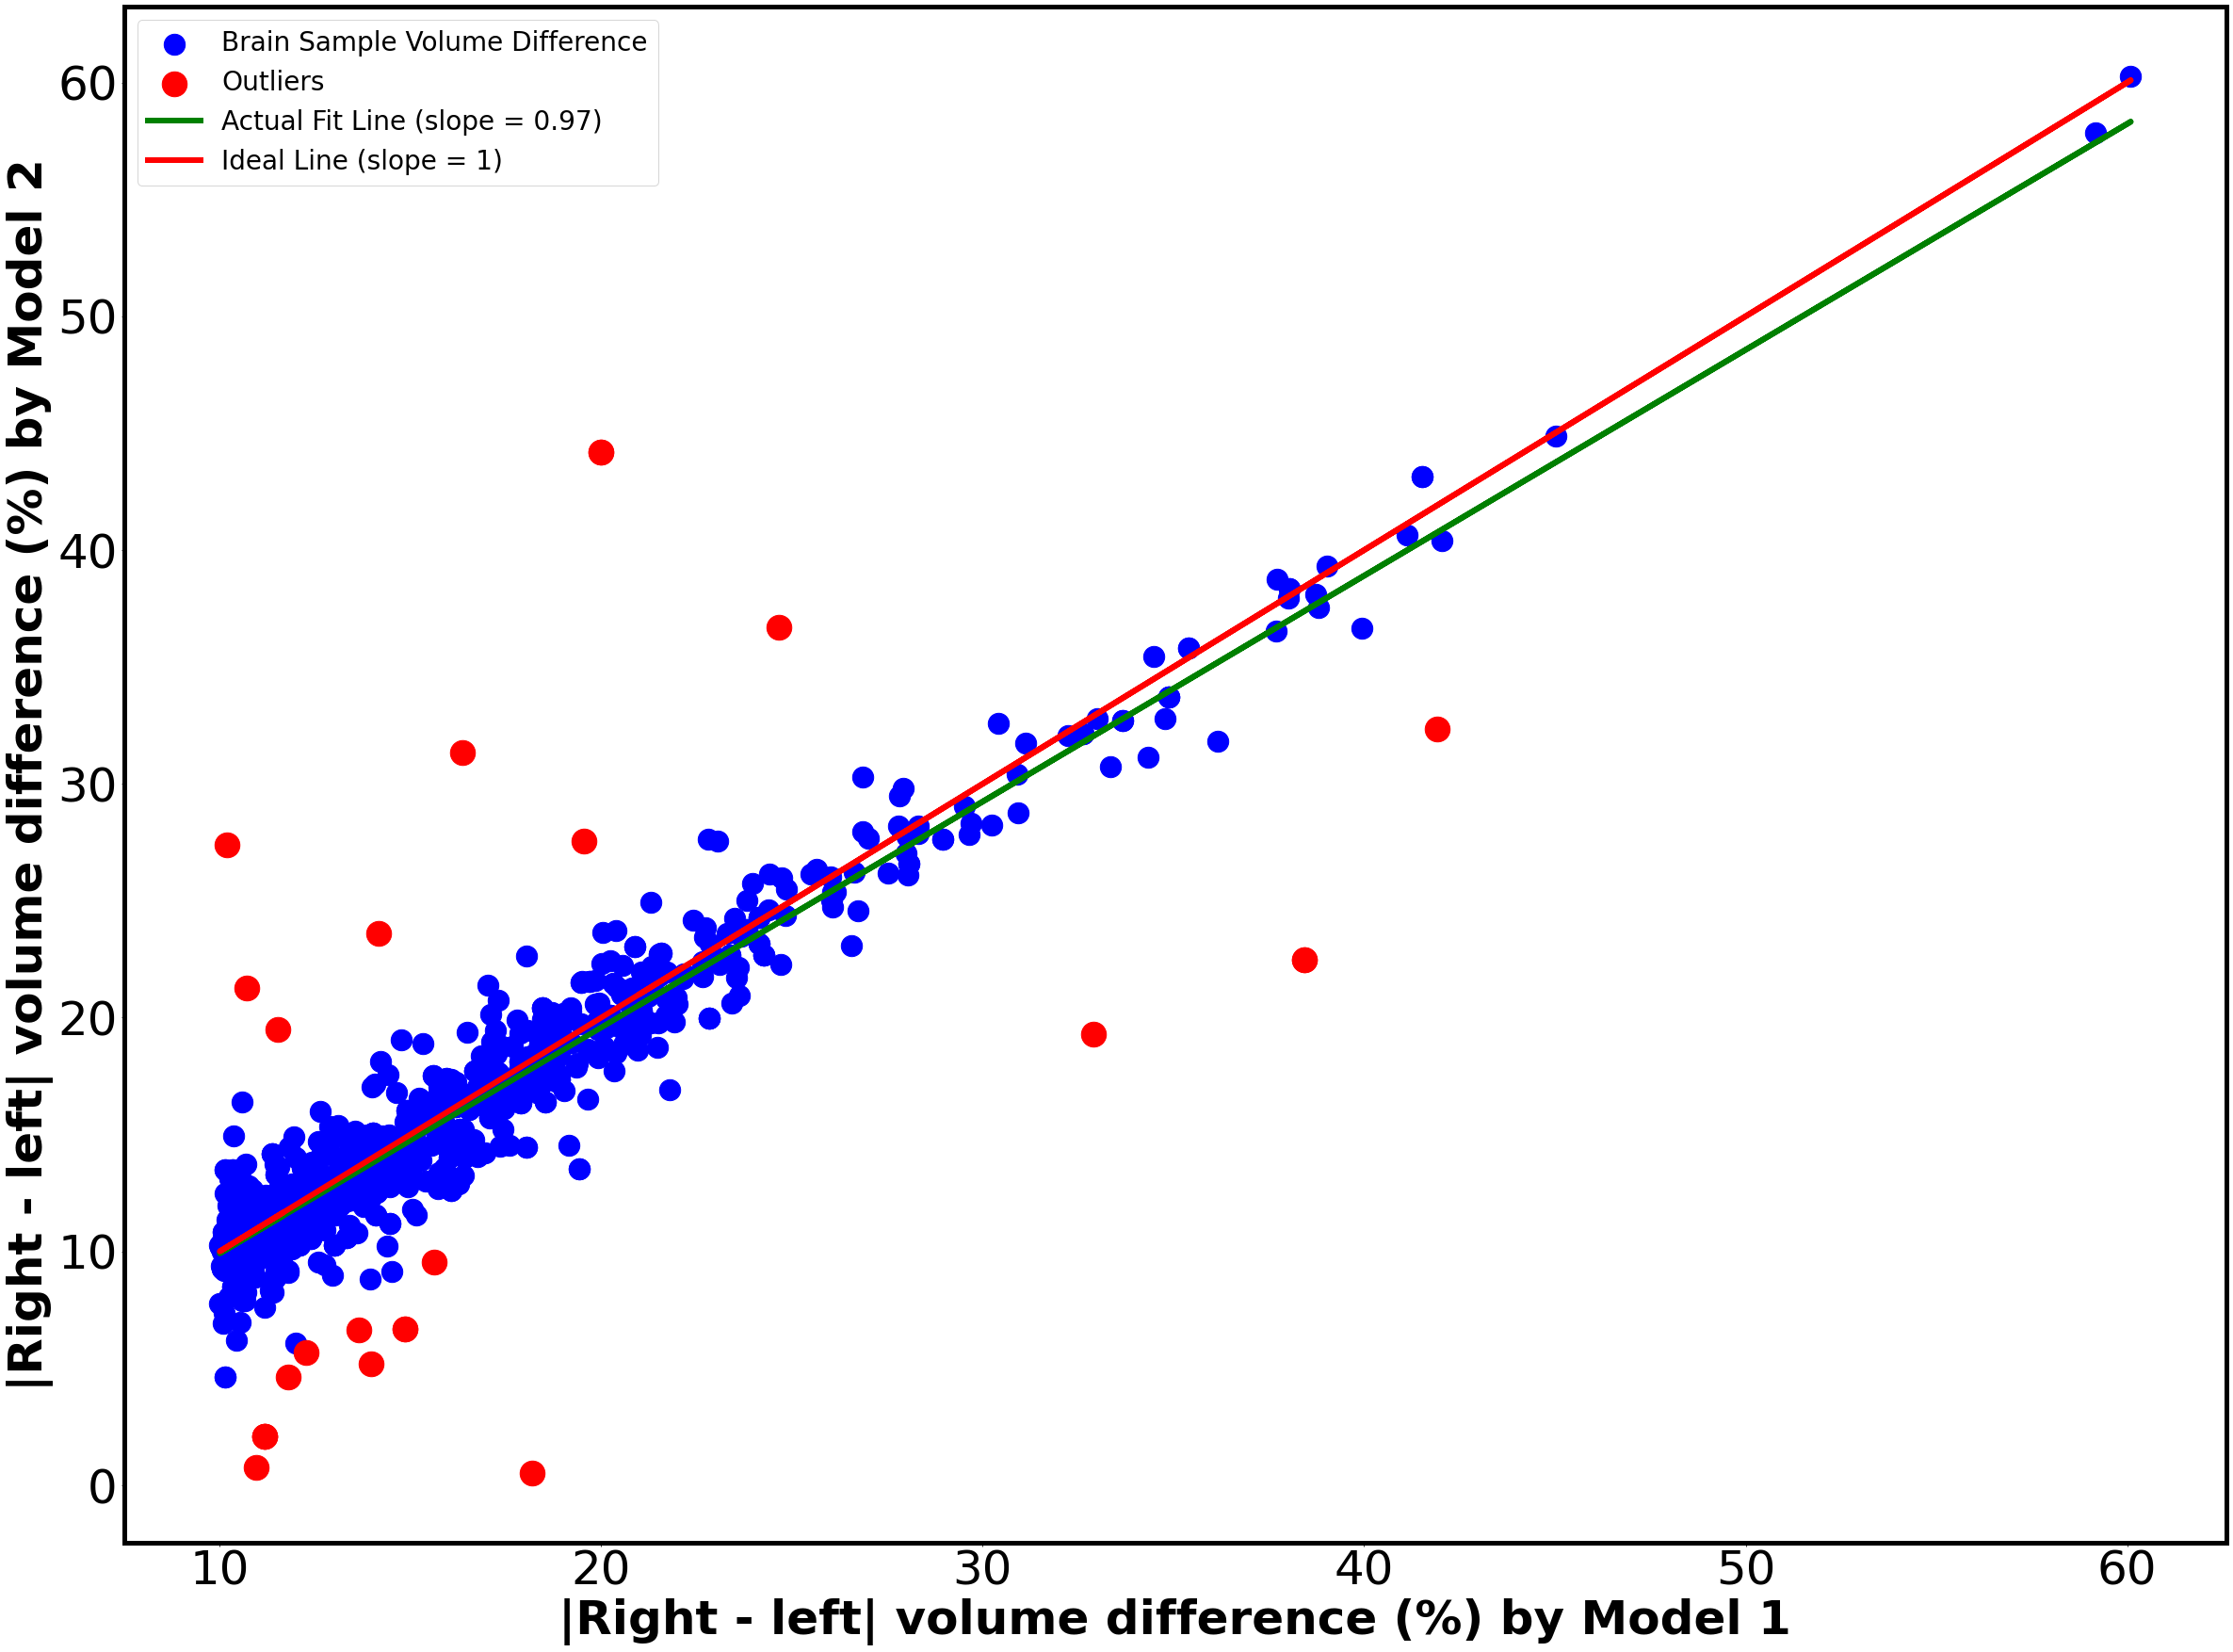

Outliers:
Brain ID: Cha-F-100071, Model 1: 11.791768579093917, Model 2: 4.630833874171703, Distance: 5.063545489484586
Brain ID: Gad1-F-900031, Model 1: 10.192969936057843, Model 2: 27.395063220221683, Distance: 12.163716811835819
Brain ID: Tdc2-F-100029, Model 1: 11.530068503738363, Model 2: 19.484394001943283, Distance: 5.6245574995457615
Brain ID: Trh-F-300006, Model 1: 16.368838880402745, Model 2: 31.3324478146928, Distance: 10.580869348460103
Brain ID: VGlut-F-000491, Model 1: 14.158779295324145, Model 2: 23.613699953301058, Distance: 6.685638512836249
Brain ID: VGlut-F-100293, Model 1: 13.960201790889087, Model 2: 5.198755960303863, Distance: 6.195277759805415
Brain ID: E0585-F-200014, Model 1: 15.632157536860708, Model 2: 9.565763901991668, Distance: 4.289588076562807
Brain ID: Cha-F-100295, Model 1: 13.656516849914368, Model 2: 6.630889598350705, Distance: 4.967868671669672
Brain ID: Trh-F-600059, Model 1: 10.960075874936948, Model 2: 0.7679481991096723, Distance: 7.20692259429

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy')
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 定义要删除的大脑ID列表
ids_to_remove = ['Seg_MB_VGlut-F-000542', 'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 过滤掉特定的大脑ID及其对应的数值
filtered_brain_ids = []
filtered_percentages = []

for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
    if brain_id not in ids_to_remove:
        filtered_brain_ids.append(brain_id)
        filtered_percentages.append(percentage)

# 将删除后的大脑名称列表赋予回原本 target_files
target_files = filtered_brain_ids
target_absolute_percentage_differences = filtered_percentages

# 提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算实际数据的趋势线
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 计算到斜率=1的直线（y=x）的垂直距离
distances = np.abs(y_coords - x_coords) / np.sqrt(2)

# 设定距离阈值（这里设为平均距离加上两倍的标准差）
threshold = np.mean(distances) + 2 * np.std(distances)

# 找到离群值索引
outliers = np.where(distances > threshold)[0]

# 标记离群值
outlier_x = x_coords[outliers]
outlier_y = y_coords[outliers]

# 绘制散点图、实际数据的趋势线和理想情况的趋势线
plt.figure(figsize=(40, 30))
plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference', s=500)
plt.scatter(outlier_x, outlier_y, color='red', label='Outliers', s=700)
plt.plot(x_coords, intercept + slope * x_coords, 'g-', label=f'Actual Fit Line (slope = {slope:.2f})', linewidth=6)
plt.plot(x_coords, x_coords, 'r-', label='Ideal Line (slope = 1)', linewidth=6)
plt.xlabel('|Right - left| volume difference (%) by Model 1', size=50, fontweight='bold')
plt.ylabel('|Right - left| volume difference (%) by Model 2', size=50, fontweight='bold')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(5)
plt.legend(fontsize=28)
plt.show()

# 打印离群值信息
print("Outliers:")
for i in outliers:
    print(f'Brain ID: {target_brain_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')


6
7
9
14


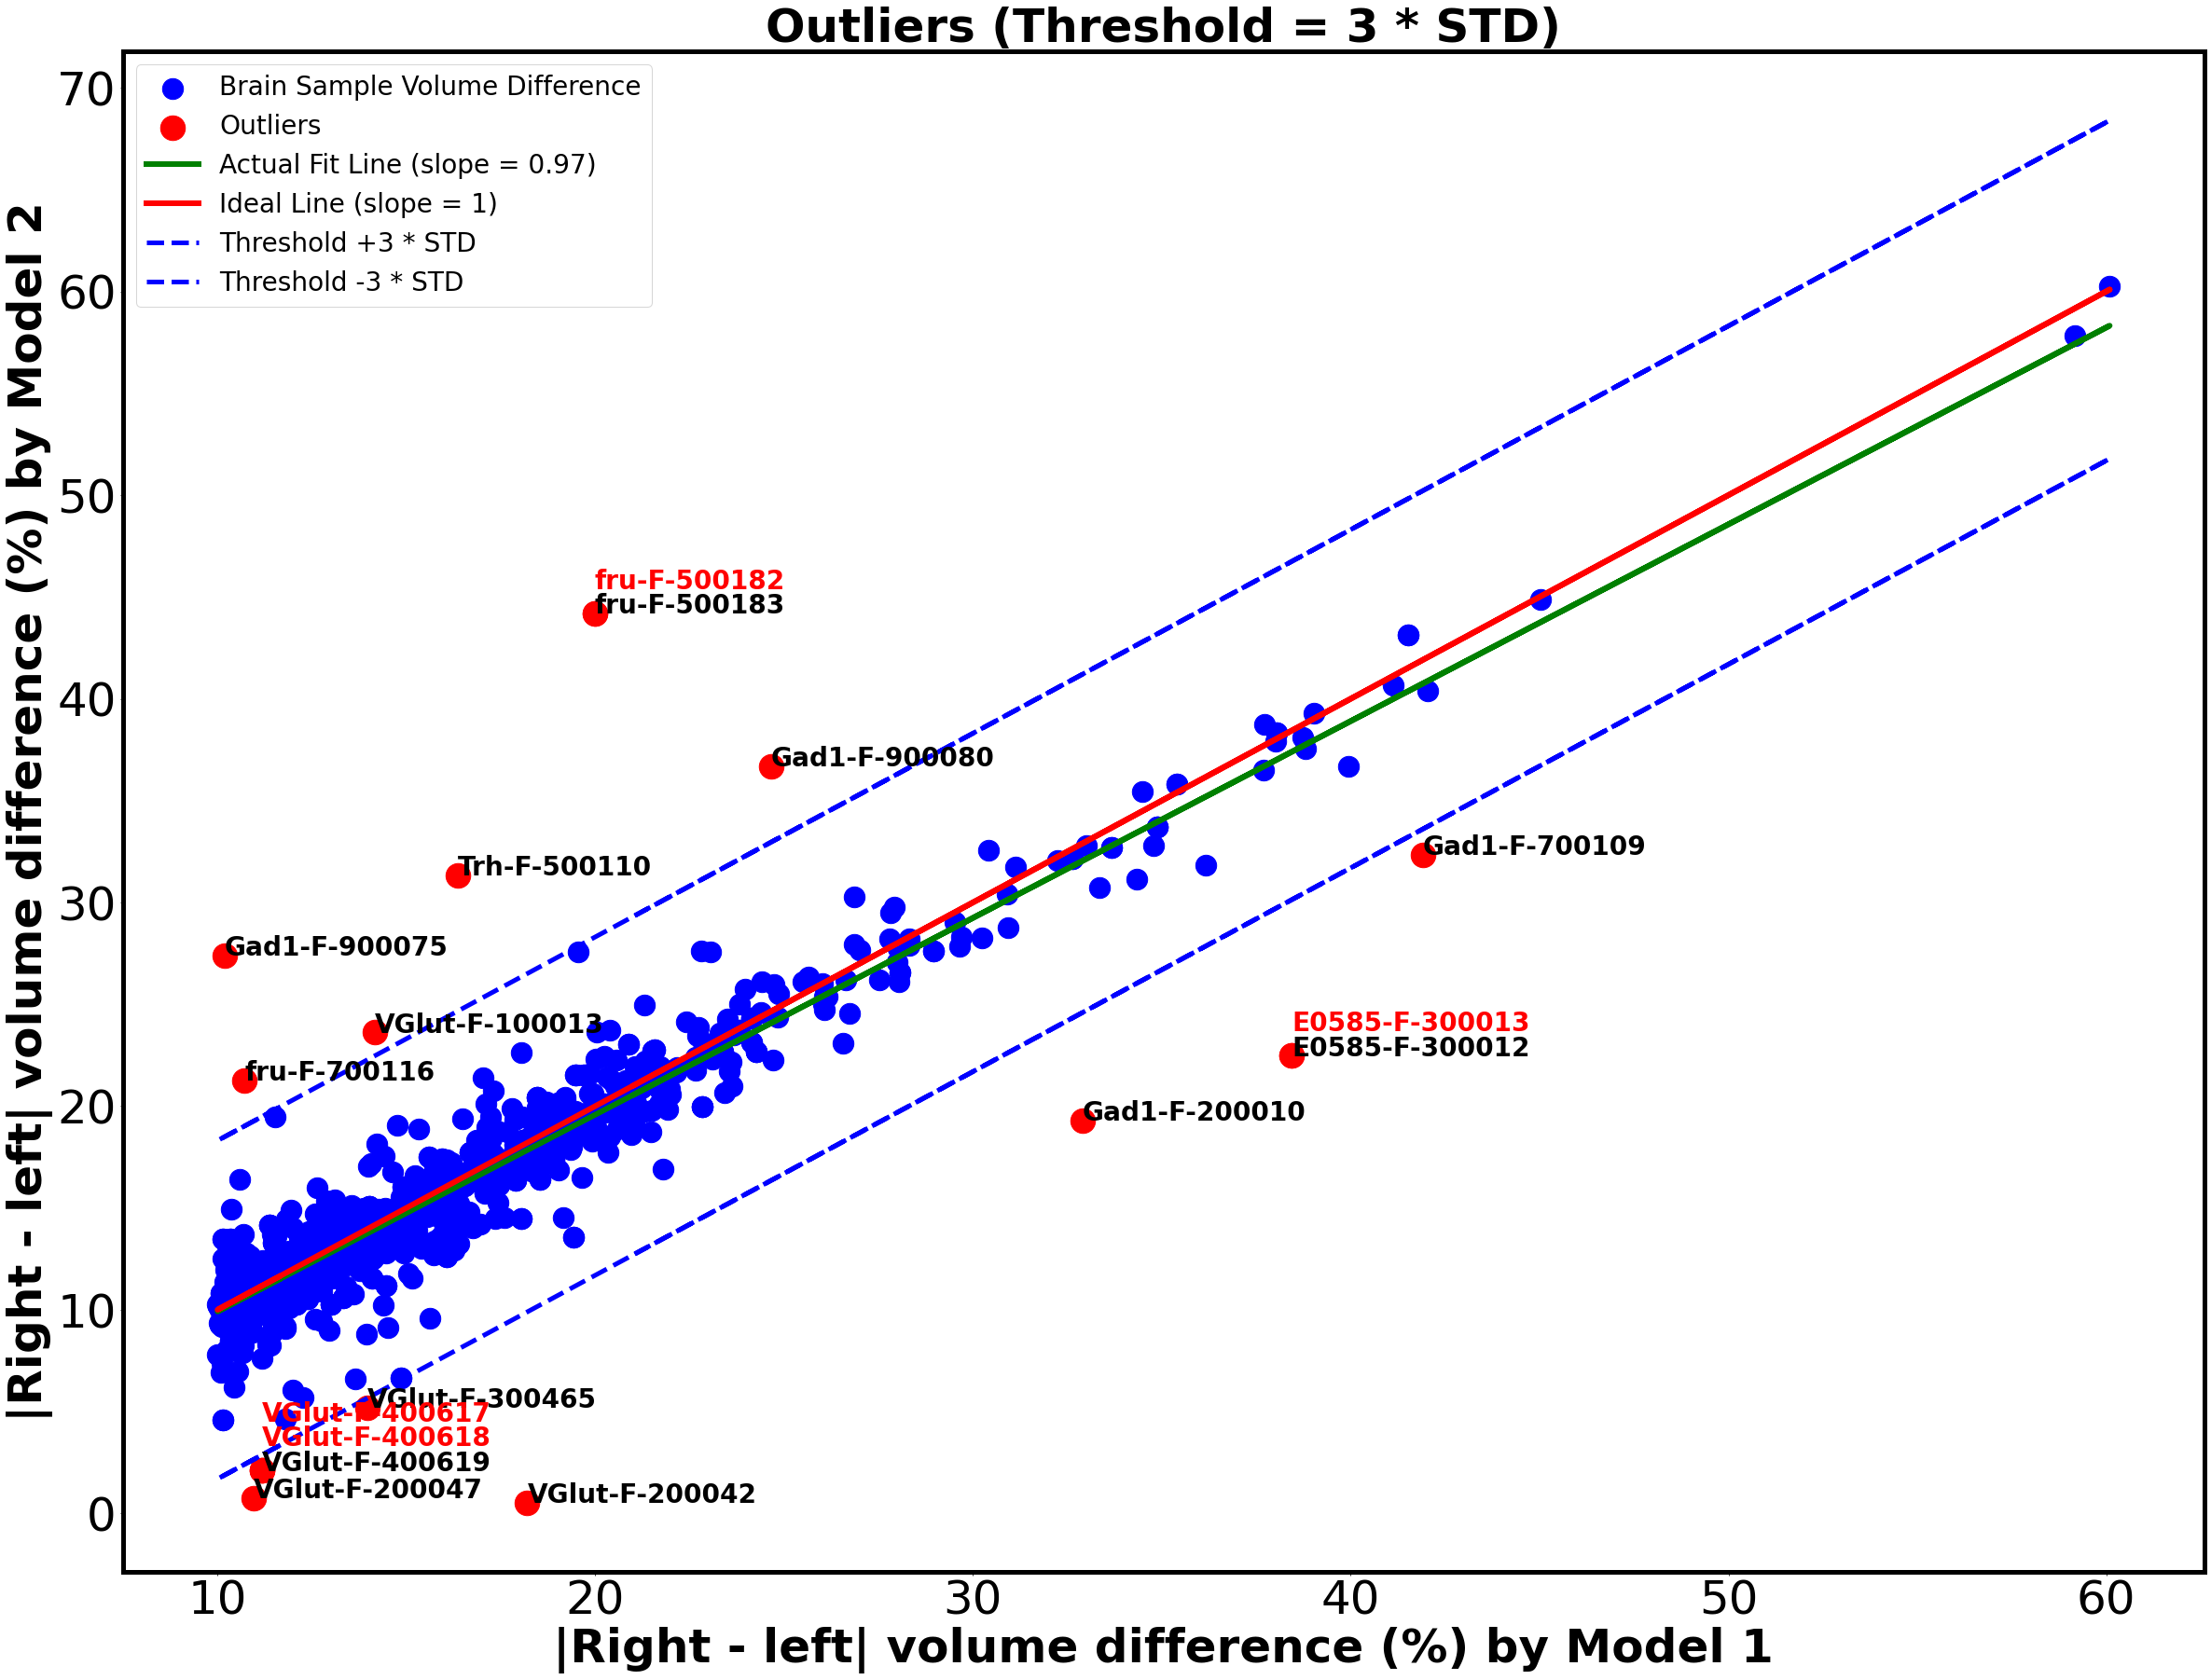

Outliers:
Brain ID: Gad1-F-900075, Model 1: 10.192969936057843, Model 2: 27.395063220221683, Distance: 12.163716811835819
Brain ID: Trh-F-500110, Model 1: 16.368838880402745, Model 2: 31.3324478146928, Distance: 10.580869348460103
Brain ID: VGlut-F-100013, Model 1: 14.158779295324145, Model 2: 23.613699953301058, Distance: 6.685638512836249
Brain ID: VGlut-F-300465, Model 1: 13.960201790889087, Model 2: 5.198755960303863, Distance: 6.195277759805415
Brain ID: VGlut-F-200047, Model 1: 10.960075874936948, Model 2: 0.7679481991096723, Distance: 7.206922594296552
Brain ID: VGlut-F-200042, Model 1: 18.202378128404195, Model 2: 0.5355947333184558, Distance: 12.492302340419023
Brain ID: VGlut-F-400617, Model 1: 11.170671371201903, Model 2: 2.104548130741626, Distance: 6.410717222402419
Brain ID: VGlut-F-400618, Model 1: 11.170671371201903, Model 2: 2.104548130741626, Distance: 6.410717222402419
Brain ID: VGlut-F-400619, Model 1: 11.170671371201903, Model 2: 2.104548130741626, Distance: 6.4107

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 加载数据
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy')
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 定义要删除的大脑ID列表
ids_to_remove = ['Seg_MB_VGlut-F-000542', 'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 过滤掉特定的大脑ID及其对应的数值
filtered_brain_ids = []
filtered_percentages = []

for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
    if brain_id not in ids_to_remove:
        filtered_brain_ids.append(brain_id)
        filtered_percentages.append(percentage)

# 将删除后的大脑名称列表赋予回原本 target_files
target_files = filtered_brain_ids
target_absolute_percentage_differences = filtered_percentages

# 提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []
# 初始化最終有使用的大腦ID 列表
final_ids = []


# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])
        final_ids.append(brain_id)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算实际数据的趋势线
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 计算到斜率=1的直线（y=x）的垂直距离
distances = np.abs(y_coords - x_coords) / np.sqrt(2)

# 设定距离阈值（这里设为平均距离加上两倍的标准差）
threshold_factor = 3
threshold = np.mean(distances) + threshold_factor * np.std(distances)

# 找到离群值索引
outliers = np.where(distances > threshold)[0]

# 标记离群值
outlier_x = x_coords[outliers]
outlier_y = y_coords[outliers]
# 這裡不應該使用 target_brain_ids(因為這是模型1的大腦編號880個)
# 應該使用篩選後的817個大腦編號
outlier_ids = [final_ids[i] for i in outliers]
# test_ids = [final_ids[i] for i in outliers]


# 计算阈值分界线的上下限
upper_threshold = x_coords + threshold * np.sqrt(2)
lower_threshold = x_coords - threshold * np.sqrt(2)

# 找出重叠的离群值坐标
coordinate_counts = defaultdict(int)
for x, y in zip(outlier_x, outlier_y):
    coordinate_counts[(x, y)] += 1

# 绘制散点图、实际数据的趋势线和理想情况的趋势线
plt.figure(figsize=(40, 30))
plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference', s=500)
plt.scatter(outlier_x, outlier_y, color='red', label='Outliers', s=700)
plt.plot(x_coords, intercept + slope * x_coords, 'g-', label=f'Actual Fit Line (slope = {slope:.2f})', linewidth=6)
plt.plot(x_coords, x_coords, 'r-', label='Ideal Line (slope = 1)', linewidth=6)
plt.plot(x_coords, upper_threshold, 'b--', label=f'Threshold +{threshold_factor} * STD', linewidth=5)
plt.plot(x_coords, lower_threshold, 'b--', label=f'Threshold -{threshold_factor} * STD', linewidth=5)
plt.xlabel('|Right - left| volume difference (%) by Model 1', size=50, fontweight='bold')
plt.ylabel('|Right - left| volume difference (%) by Model 2', size=50, fontweight='bold')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(5)

# 显示离群值的Brain ID
for i, txt in enumerate(outlier_ids):
    x, y = outlier_x[i], outlier_y[i]
    offset = 0
    color = 'r' if coordinate_counts[(x, y)] > 1 else 'black'
    if coordinate_counts[(x, y)] > 1:
        offset = (coordinate_counts[(x, y)] - 1) * 1.2  # 适当调整偏移值以避免重叠
        coordinate_counts[(x, y)] -= 1
        print(i)
    plt.annotate(txt, (x, y + offset), fontsize=28, fontweight='bold', color=color)

plt.legend(fontsize=28)
plt.title(f'Outliers (Threshold = {threshold_factor} * STD)', fontsize=50, fontweight='bold')
plt.show()
# 打印离群值信息
print("Outliers:")
for i in outliers:
    print(f'Brain ID: {final_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')


In [44]:
# 找出重叠的离群值坐标
coordinate_counts = defaultdict(int)
for x, y in zip(outlier_x, outlier_y):
    coordinate_counts[(x, y)] += 1
print('17顆有4顆重複，所以最後不重複的數量: ', len(coordinate_counts))

17顆有4顆重複，所以最後不重複的數量:  13


In [53]:
# 找出重叠的离群值坐标
coordinate_counts = defaultdict(int)
for x, y in zip(x_coords, y_coords):
    coordinate_counts[(x, y)] += 1
print('817顆有147顆重複，所以最後不重複的數量: ', len(coordinate_counts))
print('總共有13個大腦是離群值')
print('多數的大腦都在標準差內: ', 100 -(13/670*100), '%')

817顆有147顆重複，所以最後不重複的數量:  670
總共有13個大腦是離群值
多數的大腦都在標準差內:  98.05970149253731 %


In [51]:
print('重複的數量佔全部的百分比: ', 147/817*100, '%')

重複的數量佔全部的百分比:  17.99265605875153 %


In [49]:
100 -(13/670*100)

98.05970149253731

In [50]:
100-(17/817*100)

97.91921664626683

In [ ]:
# 2024/07/10 紀錄離群值和之前抽樣切割準確度 切割準確度:抽樣1000個: 失敗12個，準確度=98.8%
# 3個標準差作為閾值，離群值數量 =17
# 佔整體的 2.08%
# 最終還有97.92% 在閾值範圍內

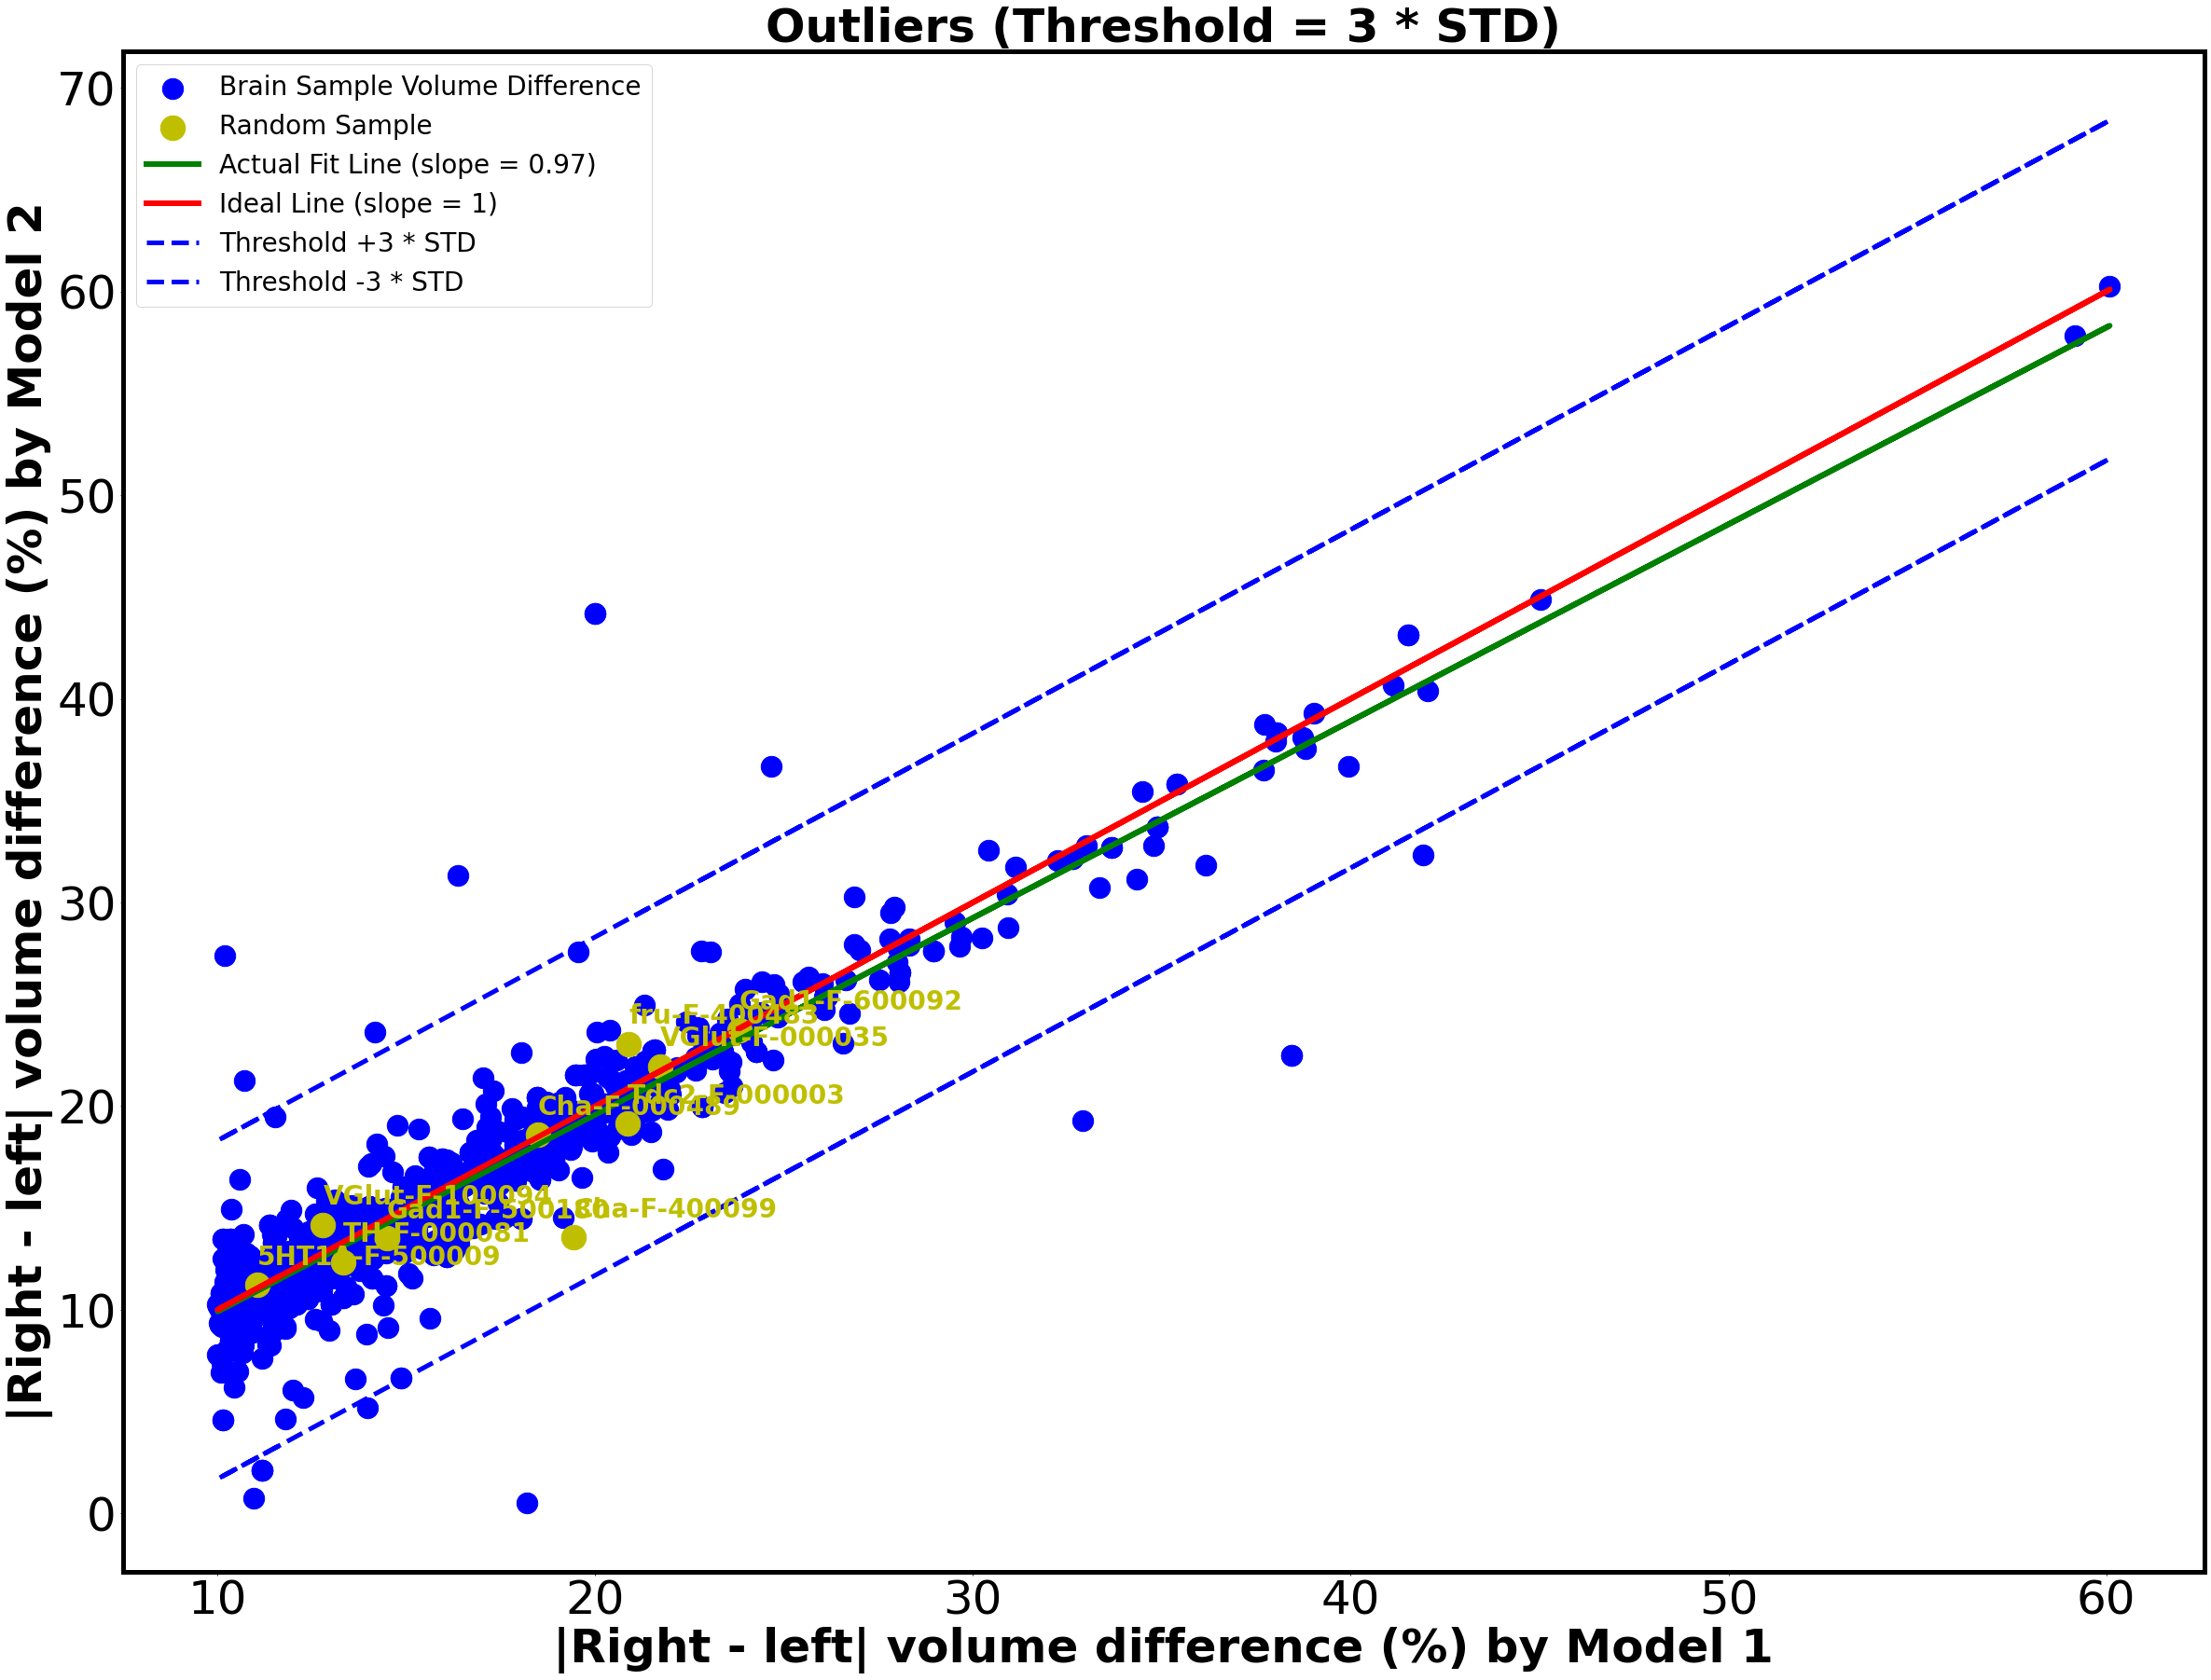

Random Sample from Non-Outliers:
Brain ID: VGlut-F-100094, Model 1: 12.794138347981448, Model 2: 14.181509288802701, Distance: 0.981019400275868
Brain ID: 5HT1A-F-500009, Model 1: 11.04535749321946, Model 2: 11.21965644795617, Distance: 0.12324797284805566
Brain ID: TH-F-000081, Model 1: 13.328925492416857, Model 2: 12.33772492605377, Distance: 0.7008846419912854
Brain ID: Cha-F-400099, Model 1: 19.43089908544347, Model 2: 13.544501892304545, Distance: 4.162311372025994
Brain ID: Gad1-F-500180, Model 1: 14.486072017858875, Model 2: 13.512342903959986, Distance: 0.6885304594766725
Brain ID: fru-F-400483, Model 1: 20.892040201722818, Model 2: 23.041633554678555, Distance: 1.5199920366685291
Brain ID: Gad1-F-600092, Model 1: 23.80692264365495, Model 2: 23.750234008525933, Distance: 0.040084918315938016
Brain ID: Cha-F-000489, Model 1: 18.485203880418627, Model 2: 18.583143517921997, Distance: 0.06925378182558482
Brain ID: VGlut-F-000035, Model 1: 21.727078372412354, Model 2: 21.9452170909

In [16]:
# 2024/07/15
# 現在要隨機抽取10個非離群值的大腦編號出來
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# 加载数据
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy')
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 定义要删除的大脑ID列表
ids_to_remove = ['Seg_MB_VGlut-F-000542', 'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 过滤掉特定的大脑ID及其对应的数值
filtered_brain_ids = []
filtered_percentages = []

for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
    if brain_id not in ids_to_remove:
        filtered_brain_ids.append(brain_id)
        filtered_percentages.append(percentage)

# 将删除后的大脑名称列表赋予回原本 target_files
target_files = filtered_brain_ids
target_absolute_percentage_differences = filtered_percentages

# 提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []
# 初始化最終有使用的大腦ID 列表
final_ids = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])
        final_ids.append(brain_id)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算实际数据的趋势线
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 计算到斜率=1的直线（y=x）的垂直距离
distances = np.abs(y_coords - x_coords) / np.sqrt(2)

# 设定距离阈值（这里设为平均距离加上三倍的标准差）
threshold_factor = 3
threshold = np.mean(distances) + threshold_factor * np.std(distances)

# 找到离群值索引
outliers = np.where(distances > threshold)[0]

# 标记离群值
outlier_x = x_coords[outliers]
outlier_y = y_coords[outliers]
outlier_ids = [final_ids[i] for i in outliers]

# 计算阈值分界线的上下限
upper_threshold = x_coords + threshold * np.sqrt(2)
lower_threshold = x_coords - threshold * np.sqrt(2)

# 找出重叠的离群值坐标
coordinate_counts = defaultdict(int)
for x, y in zip(outlier_x, outlier_y):
    coordinate_counts[(x, y)] += 1

# 随机抽取非离群值
non_outliers = np.where(distances <= threshold)[0]
random_sample_indices = np.random.choice(non_outliers, 10, replace=False)
random_sample_x = x_coords[random_sample_indices]
random_sample_y = y_coords[random_sample_indices]
random_sample_ids = [final_ids[i] for i in random_sample_indices]

# 绘制散点图、实际数据的趋势线和理想情况的趋势线
plt.figure(figsize=(40, 30))
plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference', s=500)
# plt.scatter(outlier_x, outlier_y, color='red', label='Outliers', s=700)
plt.scatter(random_sample_x, random_sample_y, color='y', label='Random Sample', s=700)
plt.plot(x_coords, intercept + slope * x_coords, 'g-', label=f'Actual Fit Line (slope = {slope:.2f})', linewidth=6)
plt.plot(x_coords, x_coords, 'r-', label='Ideal Line (slope = 1)', linewidth=6)
plt.plot(x_coords, upper_threshold, 'b--', label=f'Threshold +{threshold_factor} * STD', linewidth=5)
plt.plot(x_coords, lower_threshold, 'b--', label=f'Threshold -{threshold_factor} * STD', linewidth=5)
plt.xlabel('|Right - left| volume difference (%) by Model 1', size=50, fontweight='bold')
plt.ylabel('|Right - left| volume difference (%) by Model 2', size=50, fontweight='bold')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(5)

# # 显示离群值的Brain ID
# for i, txt in enumerate(outlier_ids):
#     x, y = outlier_x[i], outlier_y[i]
#     offset = 0
#     color = 'r' if coordinate_counts[(x, y)] > 1 else 'black'
#     if coordinate_counts[(x, y)] > 1:
#         offset = (coordinate_counts[(x, y)] - 1) * 1.2  # 适当调整偏移值以避免重叠
#         coordinate_counts[(x, y)] -= 1
#     plt.annotate(txt, (x, y + offset), fontsize=28, fontweight='bold', color=color)

# 显示随机抽取的非离群值的Brain ID
for i, txt in enumerate(random_sample_ids):
    plt.annotate(txt, (random_sample_x[i], random_sample_y[i]+1), fontsize=28, fontweight='bold', color='y')

plt.legend(fontsize=28)
plt.title(f'Outliers (Threshold = {threshold_factor} * STD)', fontsize=50, fontweight='bold')
plt.show()

# # 打印离群值信息
# print("Outliers:")
# for i in outliers:
#     print(f'Brain ID: {final_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')

# 打印随机抽取的非离群值信息
print("Random Sample from Non-Outliers:")
for i in random_sample_indices:
    print(f'Brain ID: {final_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')


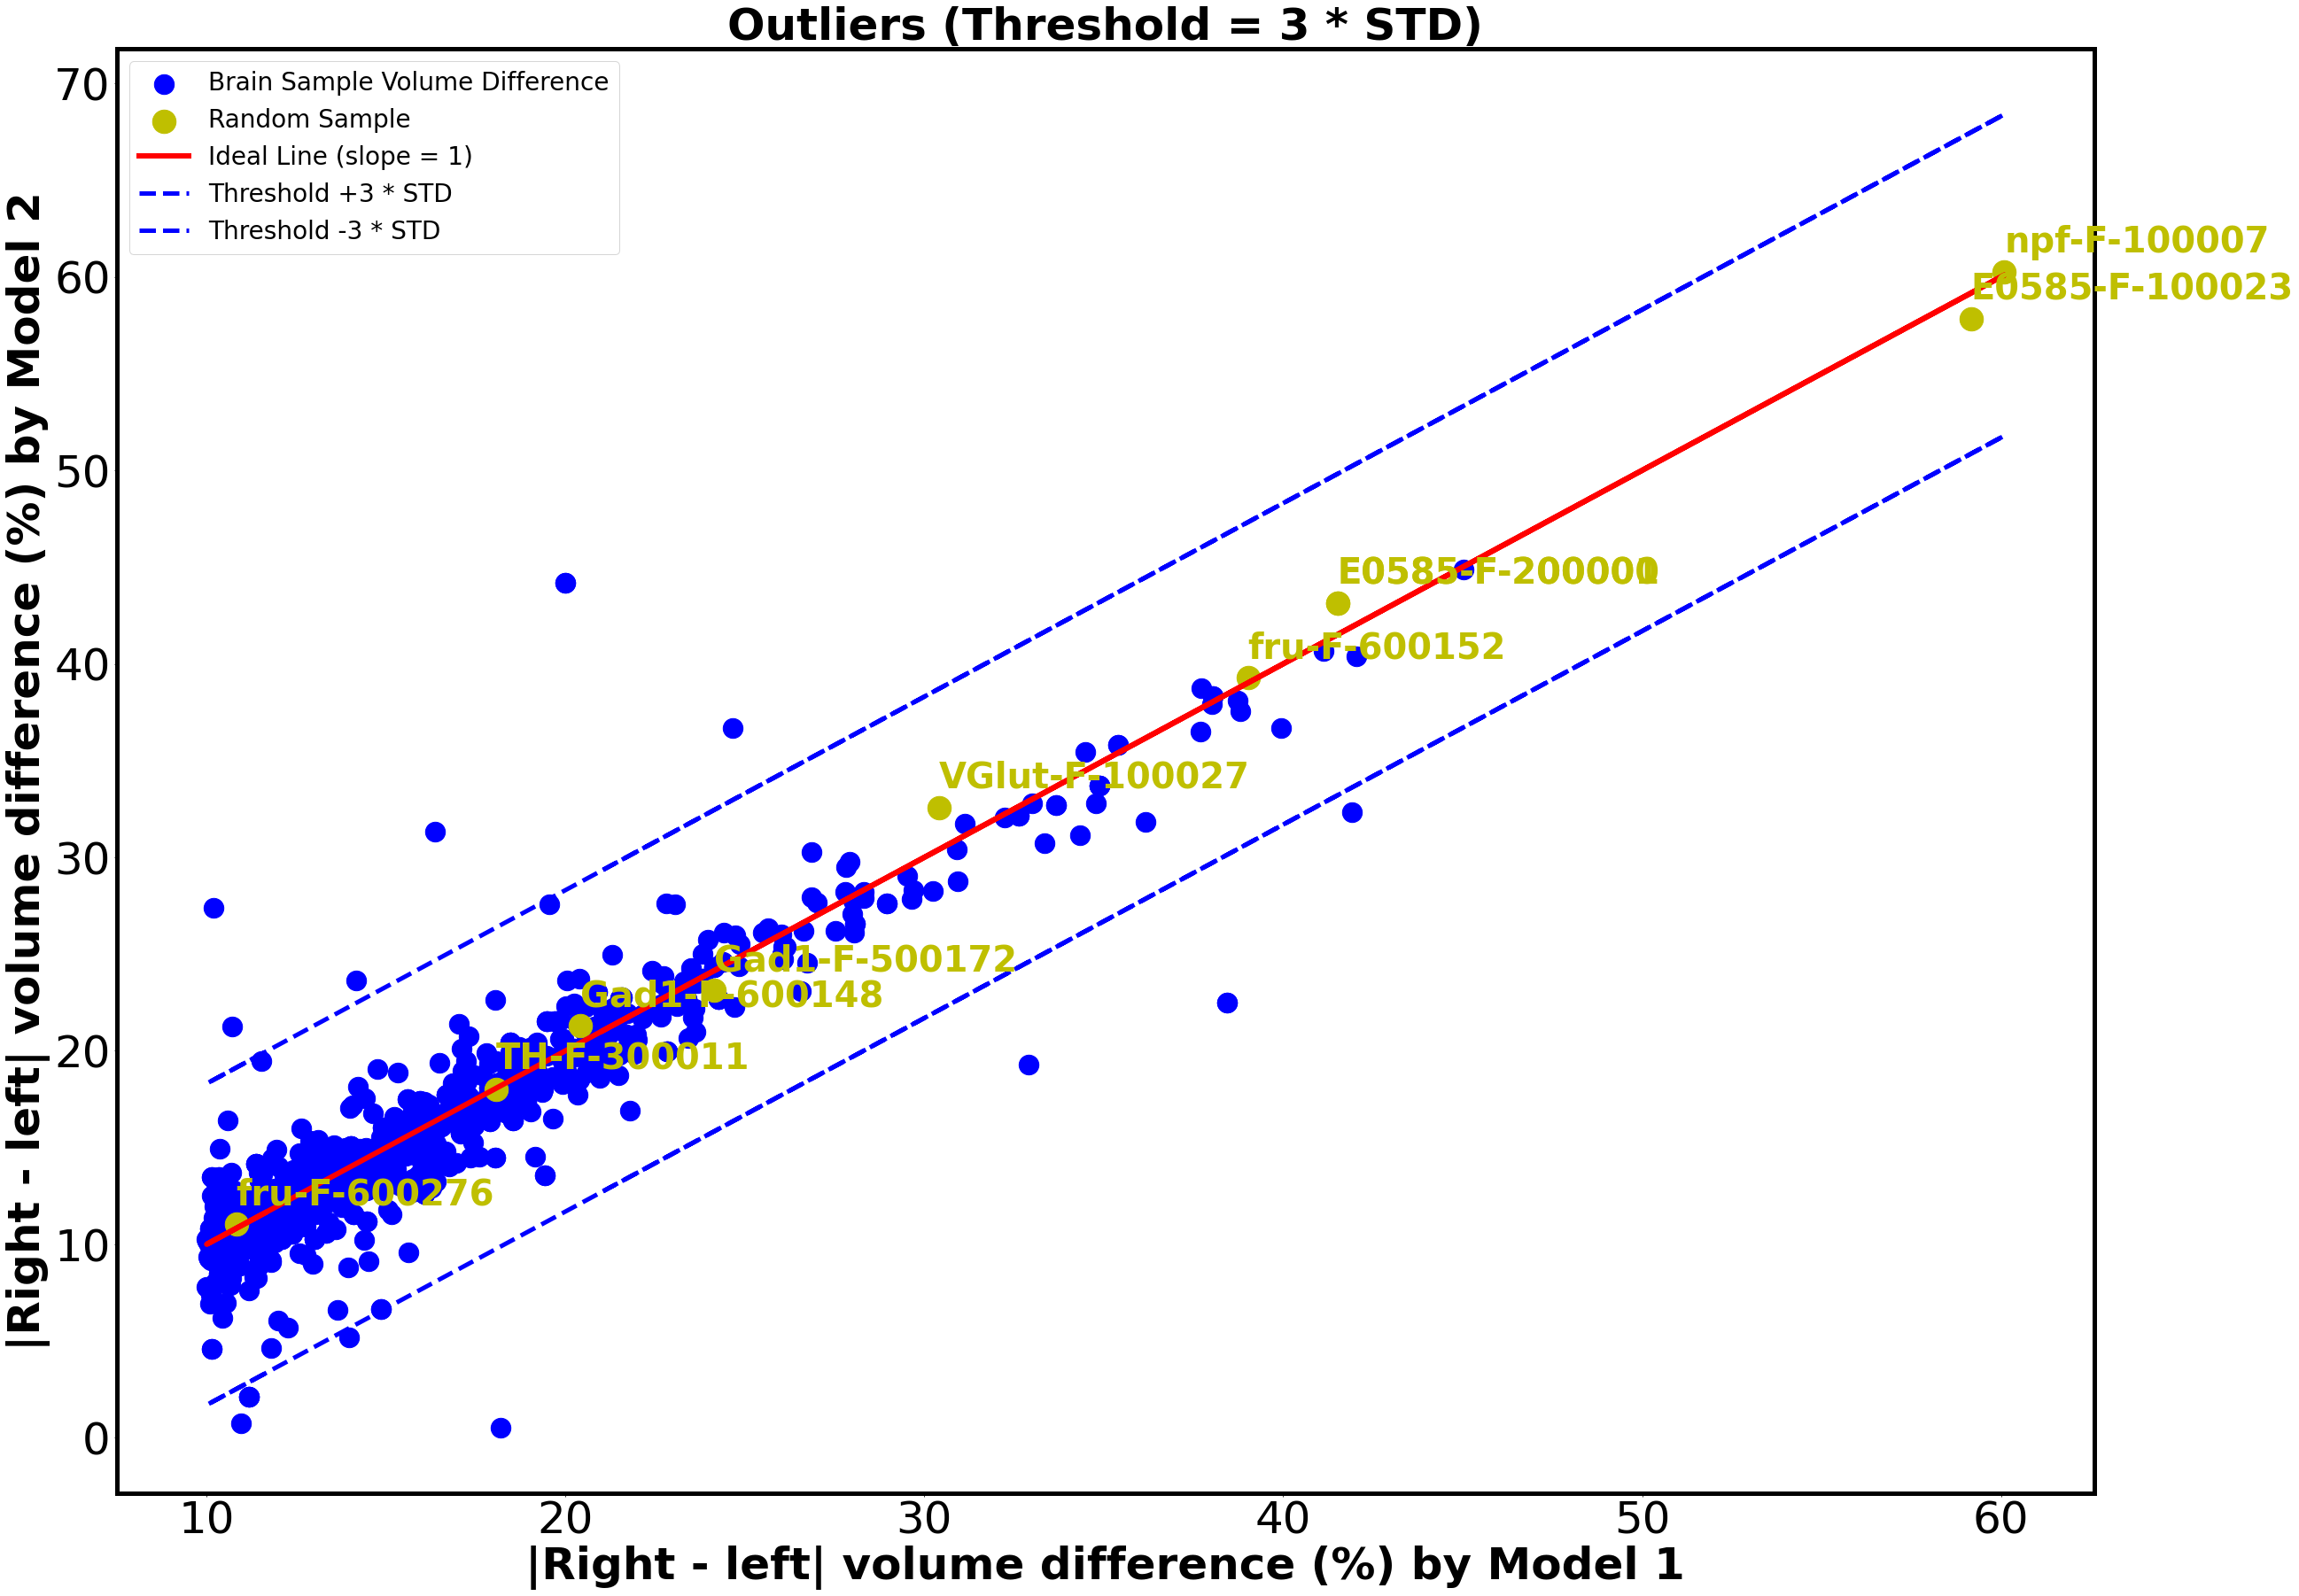

Random Sample from Non-Outliers:
Brain ID: TH-F-300011, Model 1: 18.071919230838695, Model 2: 18.02824576540575, Distance: 0.0308818035655521
Brain ID: fru-F-600276, Model 1: 10.823634395376477, Model 2: 11.03282119732902, Distance: 0.14791740619537008
Brain ID: Gad1-F-600148, Model 1: 20.406296222707905, Model 2: 21.305975228589705, Distance: 0.636169125950193
Brain ID: Gad1-F-500172, Model 1: 24.139527128237738, Model 2: 23.145655459710422, Distance: 0.7027733964448535
Brain ID: VGlut-F-100027, Model 1: 30.402893627182294, Model 2: 32.581024025232985, Distance: 1.5401707747701971
Brain ID: fru-F-600152, Model 1: 39.01895721049078, Model 2: 39.29958657688425, Distance: 0.19843492797690657
Brain ID: E0585-F-200000, Model 1: 41.51209733138035, Model 2: 43.12620951892738, Distance: 1.1413496734103565
Brain ID: E0585-F-200001, Model 1: 41.51209733138035, Model 2: 43.12620951892738, Distance: 1.1413496734103565
Brain ID: E0585-F-100023, Model 1: 59.15971981384822, Model 2: 57.8389220891327

In [32]:
# 2024/07/15
# 現在要隨機抽取10個非離群值的大腦編號出來 (這是改成從每一個區間隨機抽取2個)
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 加载数据
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy')
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 定义要删除的大脑ID列表
ids_to_remove = ['Seg_MB_VGlut-F-000542', 'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 过滤掉特定的大脑ID及其对应的数值
filtered_brain_ids = []
filtered_percentages = []

for brain_id, percentage in zip(target_files, target_absolute_percentage_differences):
    if brain_id not in ids_to_remove:
        filtered_brain_ids.append(brain_id)
        filtered_percentages.append(percentage)

# 将删除后的大脑名称列表赋予回原本 target_files
target_files = filtered_brain_ids
target_absolute_percentage_differences = filtered_percentages

# 提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in filtered_brain_ids]
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []
# 初始化最終有使用的大腦ID 列表
final_ids = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])
        final_ids.append(brain_id)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算实际数据的趋势线
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 计算到斜率=1的直线（y=x）的垂直距离
distances = np.abs(y_coords - x_coords) / np.sqrt(2)

# 设定距离阈值（这里设为平均距离加上三倍的标准差）
threshold_factor = 3
threshold = np.mean(distances) + threshold_factor * np.std(distances)

# 找到离群值索引
outliers = np.where(distances > threshold)[0]

# 标记离群值
outlier_x = x_coords[outliers]
outlier_y = y_coords[outliers]
outlier_ids = [final_ids[i] for i in outliers]

# 计算阈值分界线的上下限
upper_threshold = x_coords + threshold * np.sqrt(2)
lower_threshold = x_coords - threshold * np.sqrt(2)

# 找出重叠的离群值坐标
coordinate_counts = defaultdict(int)
for x, y in zip(outlier_x, outlier_y):
    coordinate_counts[(x, y)] += 1

# 随机抽取非离群值中的样本
non_outliers = np.where(distances <= threshold)[0]

def sample_from_range(start, end, num_samples):
    in_range = [i for i in non_outliers if start <= x_coords[i] < end]
    if len(in_range) < num_samples:
        return in_range
    return np.random.choice(in_range, num_samples, replace=False)

sample_indices = []
ranges = [(10, 20), (20, 30), (30, 40), (40, 50), (50, 61)]

for start, end in ranges:
    sample_indices.extend(sample_from_range(start, end, 2))

random_sample_x = x_coords[sample_indices]
random_sample_y = y_coords[sample_indices]
random_sample_ids = [final_ids[i] for i in sample_indices]

# 绘制散点图、实际数据的趋势线和理想情况的趋势线
plt.figure(figsize=(40, 30))
plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference', s=500)
# plt.scatter(outlier_x, outlier_y, color='red', label='Outliers', s=700)
plt.scatter(random_sample_x, random_sample_y, color='y', label='Random Sample', s=700)
# plt.plot(x_coords, intercept + slope * x_coords, 'g-', label=f'Actual Fit Line (slope = {slope:.2f})', linewidth=6)
plt.plot(x_coords, x_coords, 'r-', label='Ideal Line (slope = 1)', linewidth=6)
plt.plot(x_coords, upper_threshold, 'b--', label=f'Threshold +{threshold_factor} * STD', linewidth=5)
plt.plot(x_coords, lower_threshold, 'b--', label=f'Threshold -{threshold_factor} * STD', linewidth=5)
plt.xlabel('|Right - left| volume difference (%) by Model 1', size=50, fontweight='bold')
plt.ylabel('|Right - left| volume difference (%) by Model 2', size=50, fontweight='bold')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(5)

# # 显示离群值的Brain ID
# for i, txt in enumerate(outlier_ids):
#     x, y = outlier_x[i], outlier_y[i]
#     offset = 0
#     color = 'r' if coordinate_counts[(x, y)] > 1 else 'black'
#     if coordinate_counts[(x, y)] > 1:
#         offset = (coordinate_counts[(x, y)] - 1) * 1.2  # 适当调整偏移值以避免重叠
#         coordinate_counts[(x, y)] -= 1
#     plt.annotate(txt, (x, y + offset), fontsize=28, fontweight='bold', color=color)

# 显示随机抽取的非离群值的Brain ID
for i, txt in enumerate(random_sample_ids):
    plt.annotate(txt, (random_sample_x[i], random_sample_y[i]+1), fontsize=40, fontweight='bold', color='y')

plt.legend(fontsize=28)
plt.title(f'Outliers (Threshold = {threshold_factor} * STD)', fontsize=50, fontweight='bold')
plt.show()

# # 打印离群值信息
# print("Outliers:")
# for i in outliers:
#     print(f'Brain ID: {final_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')

# 打印随机抽取的非离群值信息
print("Random Sample from Non-Outliers:")
for i in sample_indices:
    print(f'Brain ID: {final_ids[i]}, Model 1: {x_coords[i]}, Model 2: {y_coords[i]}, Distance: {distances[i]}')


# 如果883都有成功切割，就能比對Model.V1 & Model.V2 之間的體積差異百分比之斜率
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
%matplotlib notebook
# 加载数据...
target_files = np.load('一號模型結果_883個左右腦體積差異大於10_大腦編號.npy')
target_absolute_percentage_differences = abs(np.load('一號模型結果_883個左右腦體積差異大於10_百分比數值.npy'))
used_files = np.load('客製化數據集_有處理的檔案名稱.npy')
absolute_percentage_differences = np.load('客製化數據集_有處理的體積誤差百分比.npy')

# 提取大脑ID，并且根据筛选条件过滤
target_brain_ids = [s.split('_')[-1] for s in target_files]

# 初始化 X 和 Y 坐标数组及对应的大脑ID
x_coords = []
y_coords = []
filtered_brain_ids = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])
        filtered_brain_ids.append(brain_id)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算斜率和截距
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 绘制散点图和回归线
plt.figure(figsize=(10, 5))
scatter = plt.scatter(x_coords, y_coords, color='blue', label='Brain Sample Volume Difference')
plt.plot(x_coords, intercept + slope * x_coords, 'r-', label=f'Fit Line (slope = {slope:.2f})', linewidth=4)
plt.title('Left-Right MB Neuropil Volume Difference Comparison Across Models')
plt.xlabel('Model.V1 Absolute Percentage')
plt.ylabel('Model.V2 Absolute Percentage')
# plt.xticks(fontsize=28)
# plt.yticks(fontsize=28)
plt.grid(True)
plt.legend()

# 使用 mplcursors 添加交互性
cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(filtered_brain_ids[sel.target.index]))

plt.show()


In [95]:
# 這是調閱模型2 差異>55
used_files[np.where(absolute_percentage_differences>55)]
# 這是正確的數值

array(['Seg_MB_E0585-F-100023', 'Seg_MB_npf-F-100007'], dtype='<U22')

In [ ]:
target_absolute_percentage_differences = np.array(target_absolute_percentage_differences)
target_files = np.array(target_files)
target_files[np.where(target_absolute_percentage_differences>50)]

已經提取到 1 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


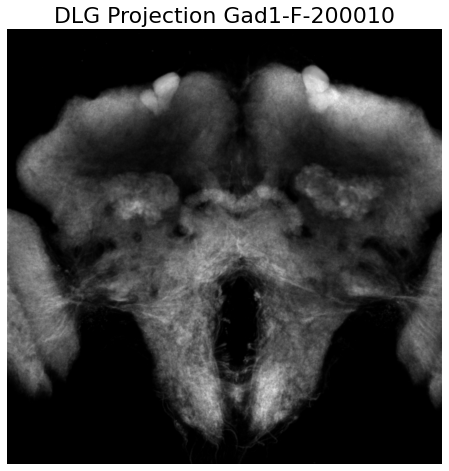

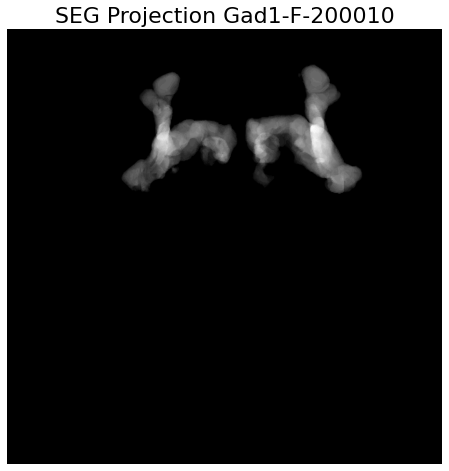

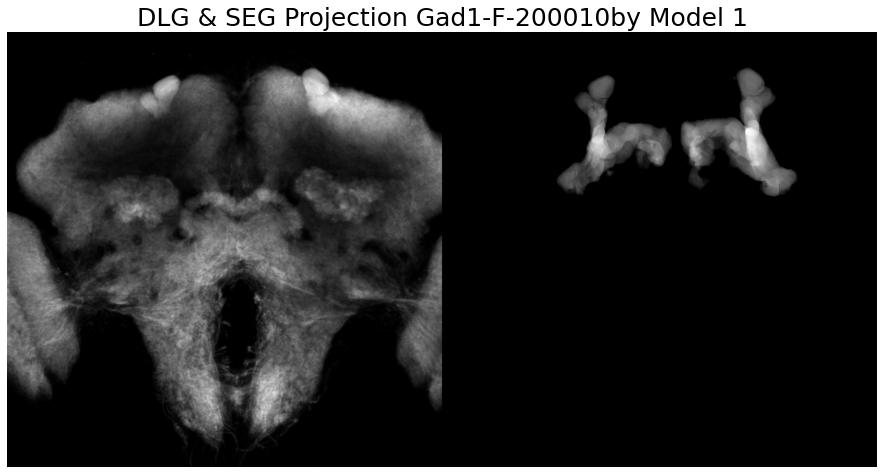

In [120]:
# 可以人工檢查特定ID大腦的圖片 ============呈現Model1的切割圖
import os
import tifffile as tif
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()

stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅')]

# 找到原始DLG和對應的Seg
# 手動輸入要讀取的大腦編號
# three_brains_names = ['Seg_MB_E0585-F-100023','Seg_MB_npf-F-100007']
# 離群值: VGlut-F-200047、fru-F-500182、E0585-F-300013、Gad1-F-200010
three_brains_names = ['Seg_MB_Gad1-F-200010']
# three_brains_names = ['Seg_MB_VGlut-F-000542',
#        'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in three_brains_names:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(three_brains_names),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

# 顯示三張合併的2D圖片
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
# 确保在 notebook 中嵌入图像
%matplotlib inline
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
start_time = time.time()  # 記錄迴圈開始的時間
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    # 显示 dlg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(dlg_projection_normalized, cmap='gray')
    plt.title("DLG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 seg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(seg_projection_normalized, cmap='gray')
    plt.title("SEG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 combined_image 图像
    plt.figure(figsize=(16, 8))
    plt.imshow(combined_image, cmap='gray')
    plt.title("DLG & SEG Projection "+seg_path.split('_')[-1].split('.')[0]+'by Model 1',size=25)
    plt.axis('off')  # 不显示坐标轴
    plt.show()


In [124]:
dlg_path

'/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集/DLG_Gad1-F-200010.tif'

已經提取到 1 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


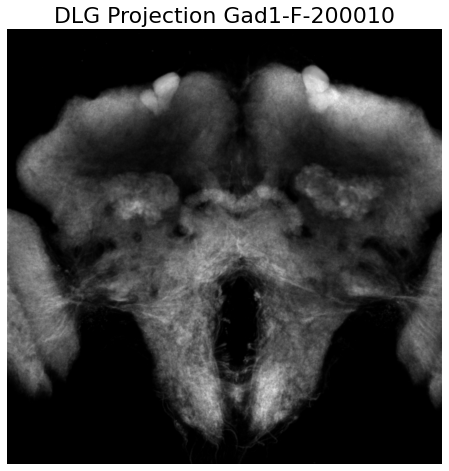

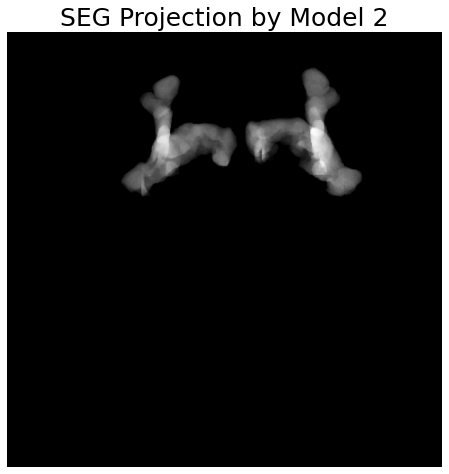

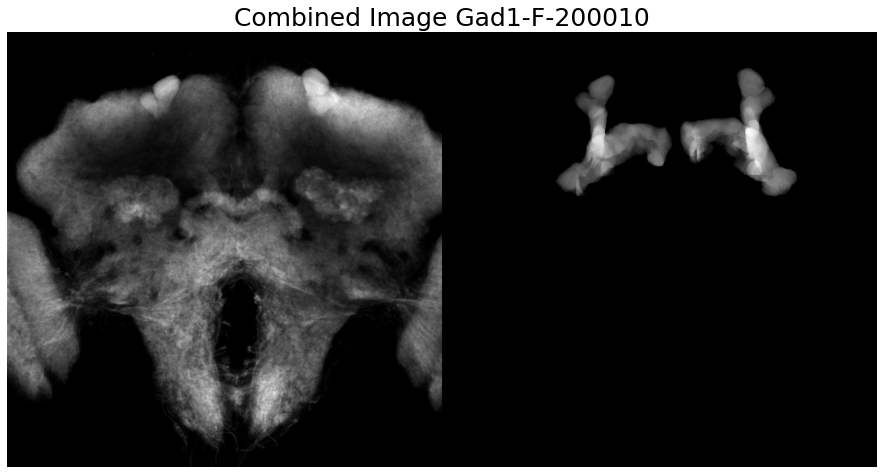

In [121]:
# 可以人工檢查特定ID大腦的圖片 ============呈現Model1的切割圖
import os
import tifffile as tif
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()

stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集')]

# 找到原始DLG和對應的Seg
# 手動輸入要讀取的大腦編號
# three_brains_names = ['Seg_MB_E0585-F-100023','Seg_MB_npf-F-100007']
# 離群值: VGlut-F-200047、fru-F-500182、E0585-F-300013、Gad1-F-200010
three_brains_names = ['Seg_MB_Gad1-F-200010']
# three_brains_names = ['Seg_MB_VGlut-F-000542',
#        'Seg_MB_VGlut-F-000543', 'Seg_MB_VGlut-F-500481']

# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in three_brains_names:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(three_brains_names),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

# 顯示三張合併的2D圖片
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
# 确保在 notebook 中嵌入图像
%matplotlib inline
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
start_time = time.time()  # 記錄迴圈開始的時間
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    # 显示 dlg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(dlg_projection_normalized, cmap='gray')
    plt.title("DLG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 seg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(seg_projection_normalized, cmap='gray')
#     plt.title("SEG Projection "+seg_path.split('_')[-1].split('.')[0]+'by Model 2',size=25)
    plt.title("SEG Projection "+'by Model 2',size=25)

    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 combined_image 图像
    plt.figure(figsize=(16, 8))
    plt.imshow(combined_image, cmap='gray')
    plt.title("Combined Image "+seg_path.split('_')[-1].split('.')[0],size=25)
    plt.axis('off')  # 不显示坐标轴
    plt.show()
